<center>
<h1><b>Homework 3</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 16, 2020</b></h3>
</center>
<hr>

### Imports

In [1]:
from scipy.integrate import solve_ivp, quad
from functools import partial
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from astroquery.jplhorizons import Horizons
import astropy as astr
from tqdm import tqdm

### Settings

In [2]:
np.set_printoptions(sign=' ', linewidth=100, precision=4, suppress=True)
plt.style.use('dark_background')

### Load External Files

In [3]:
%run src/laplacian.py
%run src/jacobi.py
%run src/sor.py

# Problem 1
## 4.10 (p.113)
Calculate the precession of the perihelion of Mercury, following the approach described in this section.

Only consider the correction coming from general relativity (ignore other Solar System planets).

In [4]:
sun_mass = 1.9885e30  # [kg]
earth_mass = 5.97e24  # [kg]
moon_mass = 7.3459e22  # [kg]
G = 6.67408e-11  # [Nm^2/kg^2]
AU = 149597870700  # [m/s]
year = 365.25636  # [day]
day = 86400  # [s]

sun_radius = 6.957e8  # [m]
mercury_radius = 2.44e6  # [m]
smallest_radius = min(sun_radius, mercury_radius)

In [5]:
sun     = Horizons( id=10, location='@sun', id_type='majorbody')
mercury = Horizons(id=199, location='@sun', id_type='majorbody')
astr.table.vstack([sun.vectors(), mercury.vectors()])

<Table length=2>
  targetname     datetime_jd    ...       range             range_rate    
     ---              d         ...         AU                AU / d      
    str13          float64      ...      float64             float64      
------------- ----------------- ... ------------------ -------------------
     Sun (10) 2459150.409937186 ...                0.0                 0.0
Mercury (199) 2459150.409943832 ... 0.3159248076519716 -0.0031193819343482

In [6]:
M_sun = 1.9885e30  # [kg]
M_mercury = 3.3011e23  # [kg]
G = 6.67408e-11  # [N*kg**(-1)*s**(-2)]
c = 299792458.0  # [m/s]

P = 87.9691  # [days]
AU = 149597870700  # [m]
day = 86400  # [s]

alpha = 1.1e-8
G = 2.959e-4
M_sun /= M_sun
M_mercury/= M_sun

In [7]:
def rhs(t, state, alpha=alpha, G=G):
    r, dr = np.hsplit(state, 2)
    return np.hstack((dr, -G * (1 + alpha / norm(r) ** 2) * r / norm(r) ** 3 ))

In [8]:
obj = Horizons(id=1, location='@sun', id_type='majorbody')
vectors = obj.vectors()
pos = np.asarray([vectors['x'], vectors['y'], vectors['z']]).ravel()
vel = np.asarray([vectors['vx'], vectors['vy'], vectors['vz']]).ravel()

In [9]:
L = np.linalg.norm(np.cross(M_mercury * vel, pos))
df = partial(rhs, alpha=1000*alpha, G=G)
state0 = np.hstack((pos, vel))

In [10]:
t_f = 250 * P

sol = solve_ivp(df, [0, t_f], state0, t_eval=np.linspace(0, t_f, 100 * int(t_f)), rtol=1.0e-6, atol=1.0e-6, method='LSODA')
t, (pos, vel) = sol.t, np.vsplit(sol.y, 2)  # unpack

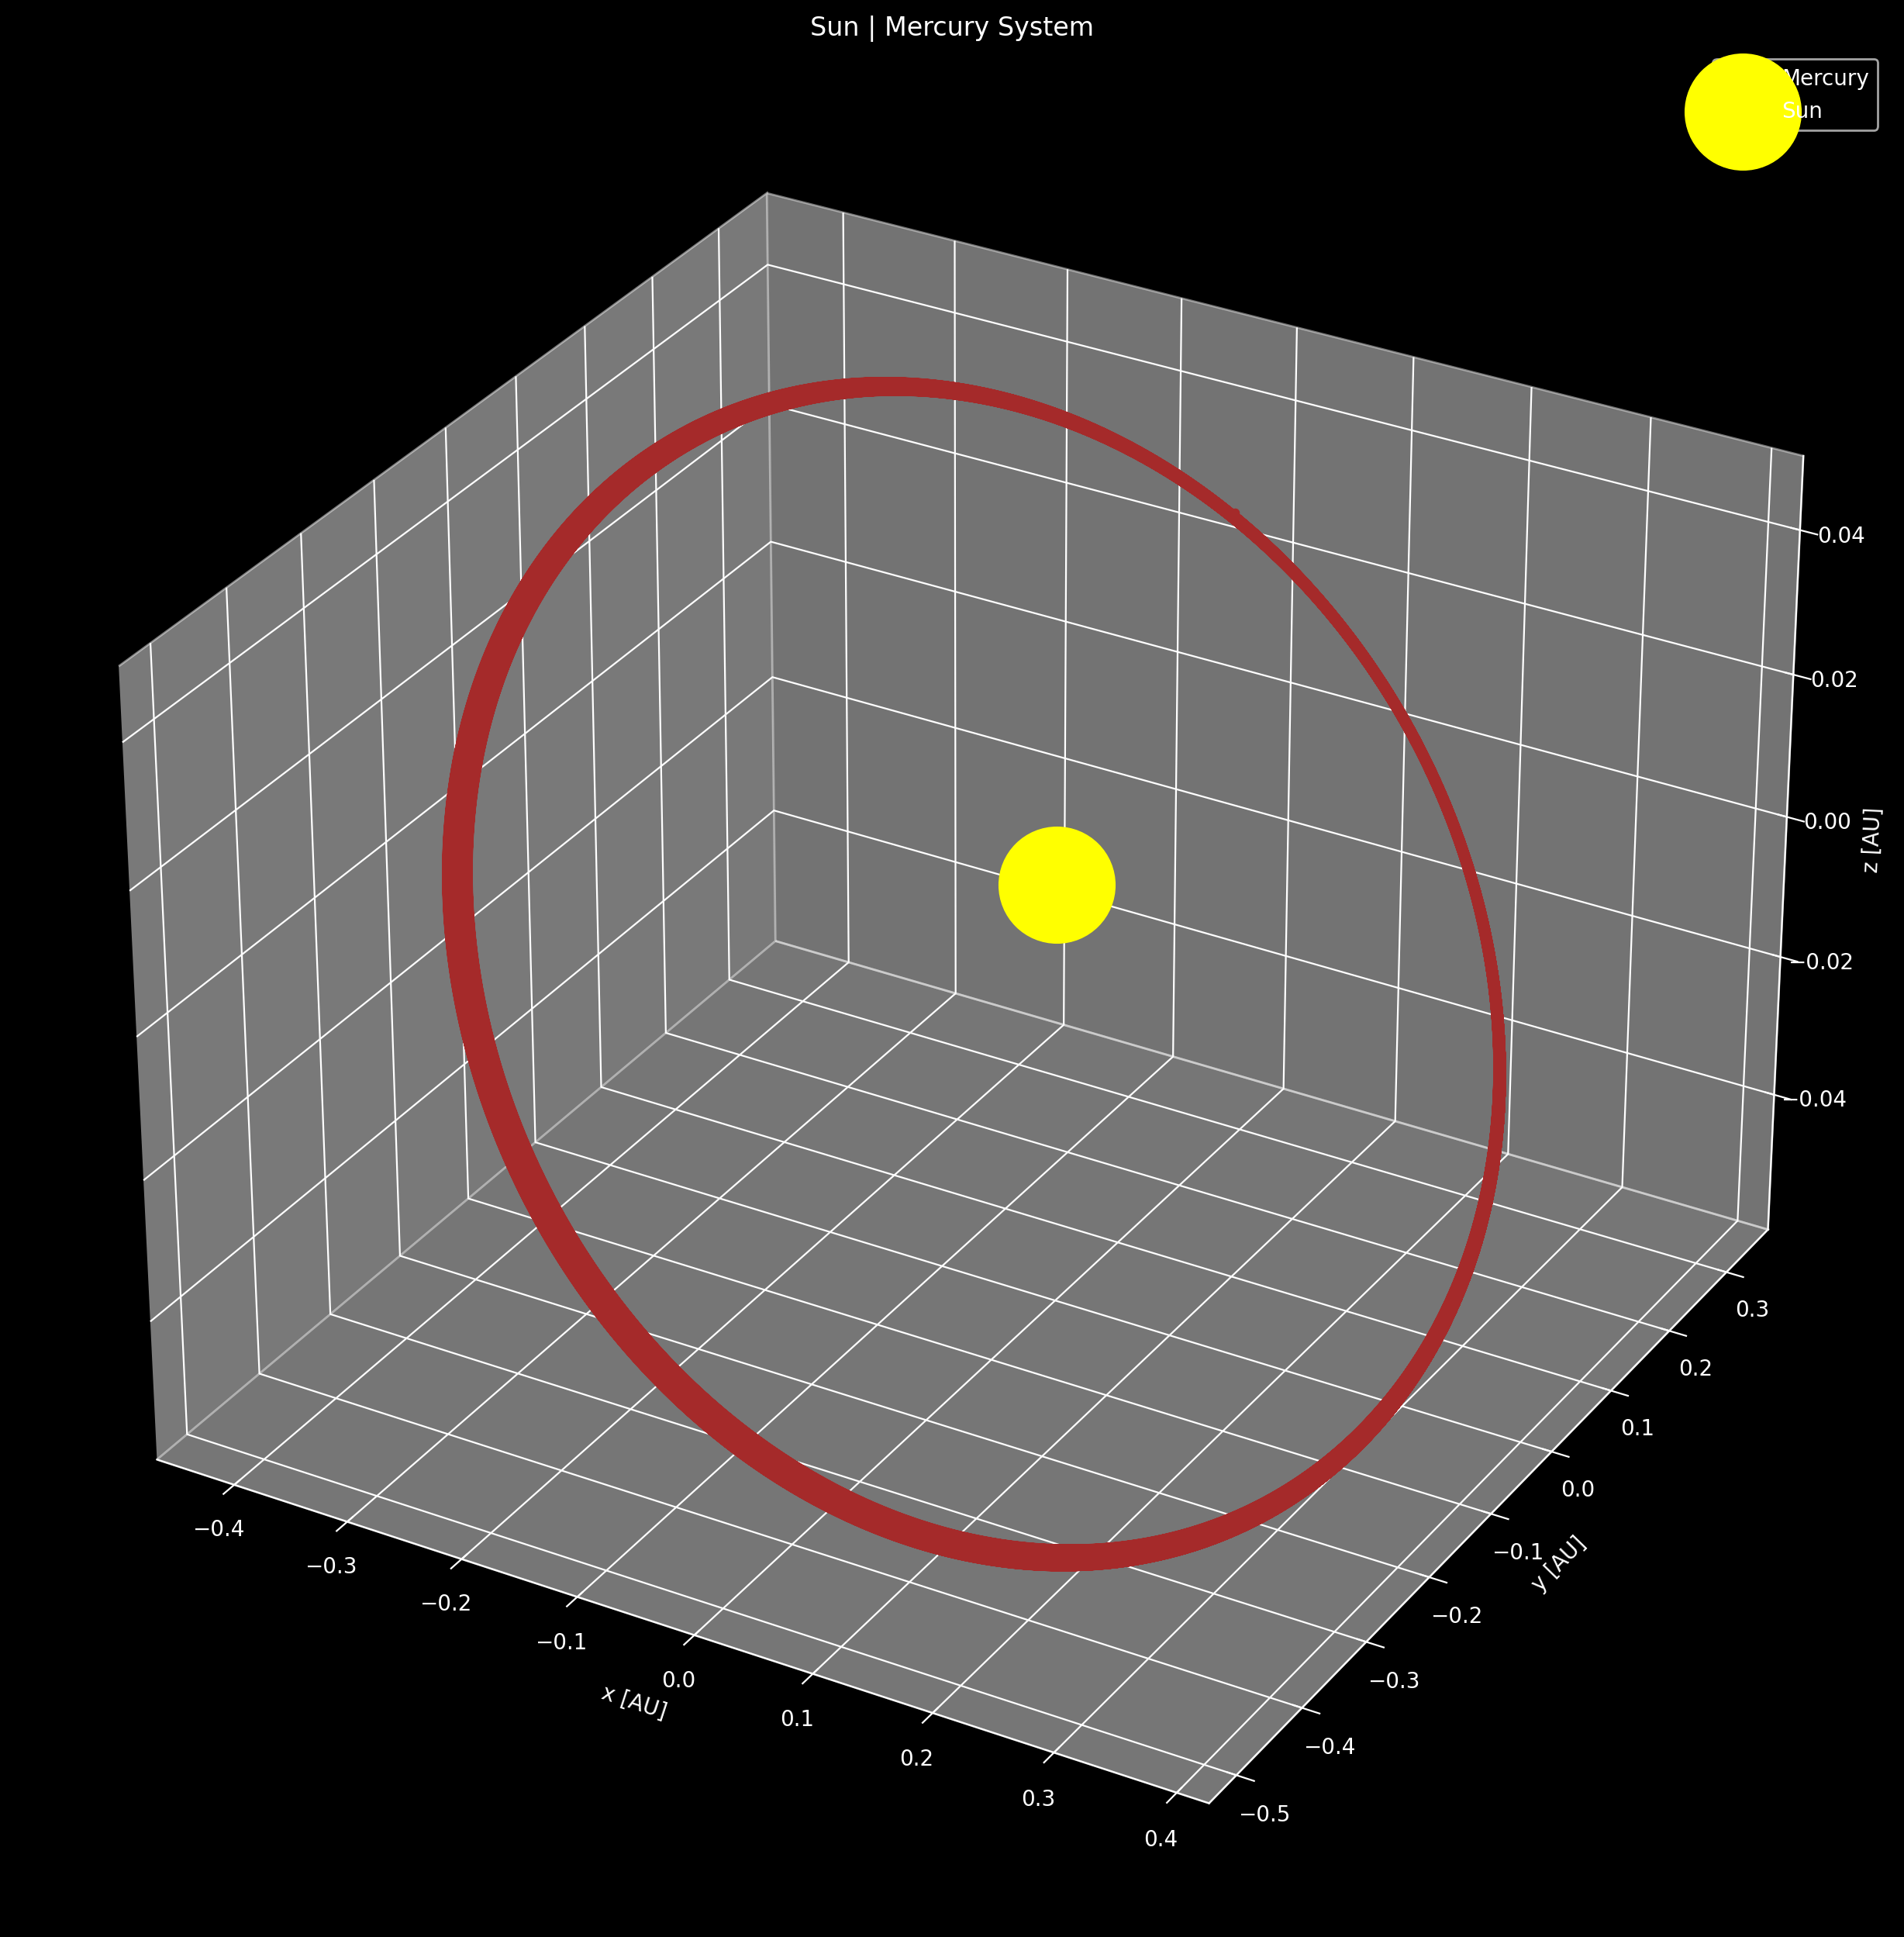

In [11]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Sun | Mercury System')
ax.plot(pos[0,:], pos[1,:], pos[2,:], color='brown')
ax.scatter(pos[0,-1], pos[1,-1], pos[2,-1], label=r'Mercury', color='brown', s=10 * mercury_radius / smallest_radius)
ax.scatter(0, 0, 0, label=r'Sun', color="yellow",  s=10 * sun_radius / smallest_radius)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
plt.legend()
plt.savefig('plots/P1a_plot.png')

# Problem 2
## 4.14 (p.118)

Simulate the orbits of Earth and Moon in the solar system by writing a program that accurately tracks the motions of both as they move about the Sun. Be careful about (1) the different time scales present in this problem, and (2) the correct initial velocities (ie., set the initial velocity of Moon taking into account the motion of Earth around which it rotates).

Also run your code for a hypothetical ”Moon” that has either the same mass as Earth (e.g., binary planets), or a rather elliptical orbit.

In [12]:
sun   = Horizons( id=10, location='@sun', id_type='majorbody')
earth = Horizons(id=399, location='@sun', id_type='majorbody')
moon  = Horizons(id=301, location='@sun', id_type='majorbody')
astr.table.vstack([sun.vectors(), earth.vectors(), moon.vectors()])

<Table length=3>
 targetname    datetime_jd    ...       range              range_rate      
    ---             d         ...         AU                 AU / d        
   str11         float64      ...      float64              float64        
----------- ----------------- ... ------------------ ----------------------
   Sun (10) 2459150.410024815 ...                0.0                    0.0
Earth (399) 2459150.410031541 ... 0.9935730047795595 -0.0002715922035275861
 Moon (301) 2459150.410038543 ... 0.9956202102767708  7.327702185758273e-05

In [13]:
sun_mass = 1.9885e30  # [kg]
earth_mass = 5.97e24  # [kg]
moon_mass = 7.3459e22  # [kg]
G = 6.67408e-11  # [Nm^2/kg^2]
AU = 149597870700  # [m/s]
year = 365.25636  # [day]
day = 86400  # [s]

sun_radius = 6.957e8  # [m]
earth_radius = 6.371009e6  # [m]
moon_radius = 1.7374e6  # [m]
smallest_radius = min(sun_radius, earth_radius, moon_radius)

sun_mass /= AU ** 3 / (G * day ** 2)
earth_mass /= AU ** 3 / (G * day ** 2)
moon_mass /= AU ** 3 / (G * day ** 2)

In [14]:
def rhs(t, state, m0=sun_mass, m1=earth_mass, m2=moon_mass):
    r0, r1, r2, dr0, dr1, dr2 = np.hsplit(state, 6)
    return np.hstack((
        dr0, 
        dr1,
        dr2, 
        -m1 * (r0 - r1) / norm(r0 - r1) ** 3 - m2 * (r0 - r2) / norm(r0 - r2) ** 3,
        -m0 * (r1 - r0) / norm(r1 - r0) ** 3 - m2 * (r1 - r2) / norm(r1 - r2) ** 3,
        -m0 * (r2 - r0) / norm(r2 - r0) ** 3 - m1 * (r2 - r1) / norm(r2 - r1) ** 3
        ))

In [15]:
sun_vectors = sun.vectors()
sun_pos = np.asarray([sun_vectors['x'], sun_vectors['y'], sun_vectors['z']]).ravel()
sun_vel = np.asarray([sun_vectors['vx'], sun_vectors['vy'], sun_vectors['vz']]).ravel()

earth_vectors = earth.vectors()
earth_pos = np.asarray([earth_vectors['x'], earth_vectors['y'], earth_vectors['z']]).ravel()
earth_vel = np.asarray([earth_vectors['vx'], earth_vectors['vy'], earth_vectors['vz']]).ravel()

moon_vectors  = moon.vectors()
moon_pos = np.asarray([moon_vectors['x'], moon_vectors['y'], moon_vectors['z']]).ravel()
moon_vel = np.asarray([moon_vectors['vx'], moon_vectors['vy'], moon_vectors['vz']]).ravel()

state0 = np.hstack((sun_pos, earth_pos, moon_pos, sun_vel, earth_vel, moon_vel))

In [16]:
t_f = year
step_density = 100

sol = solve_ivp(rhs, [0, t_f], state0, t_eval=np.linspace(0, t_f, int(step_density * t_f)), rtol=1.0e-4, atol=1.0e-6, method="LSODA")  # Using 'LSODA' to account for the stiffness of the problem
if sol.success is True:
    t, (pos, vel) = sol.t, np.vsplit(sol.y, 2)
    (sun_pos, earth_pos, moon_pos), (sun_vel, earth_vel, moon_vel) = np.vsplit(pos, 3), np.vsplit(vel, 3)
else:
    print('Error!', sol.message)

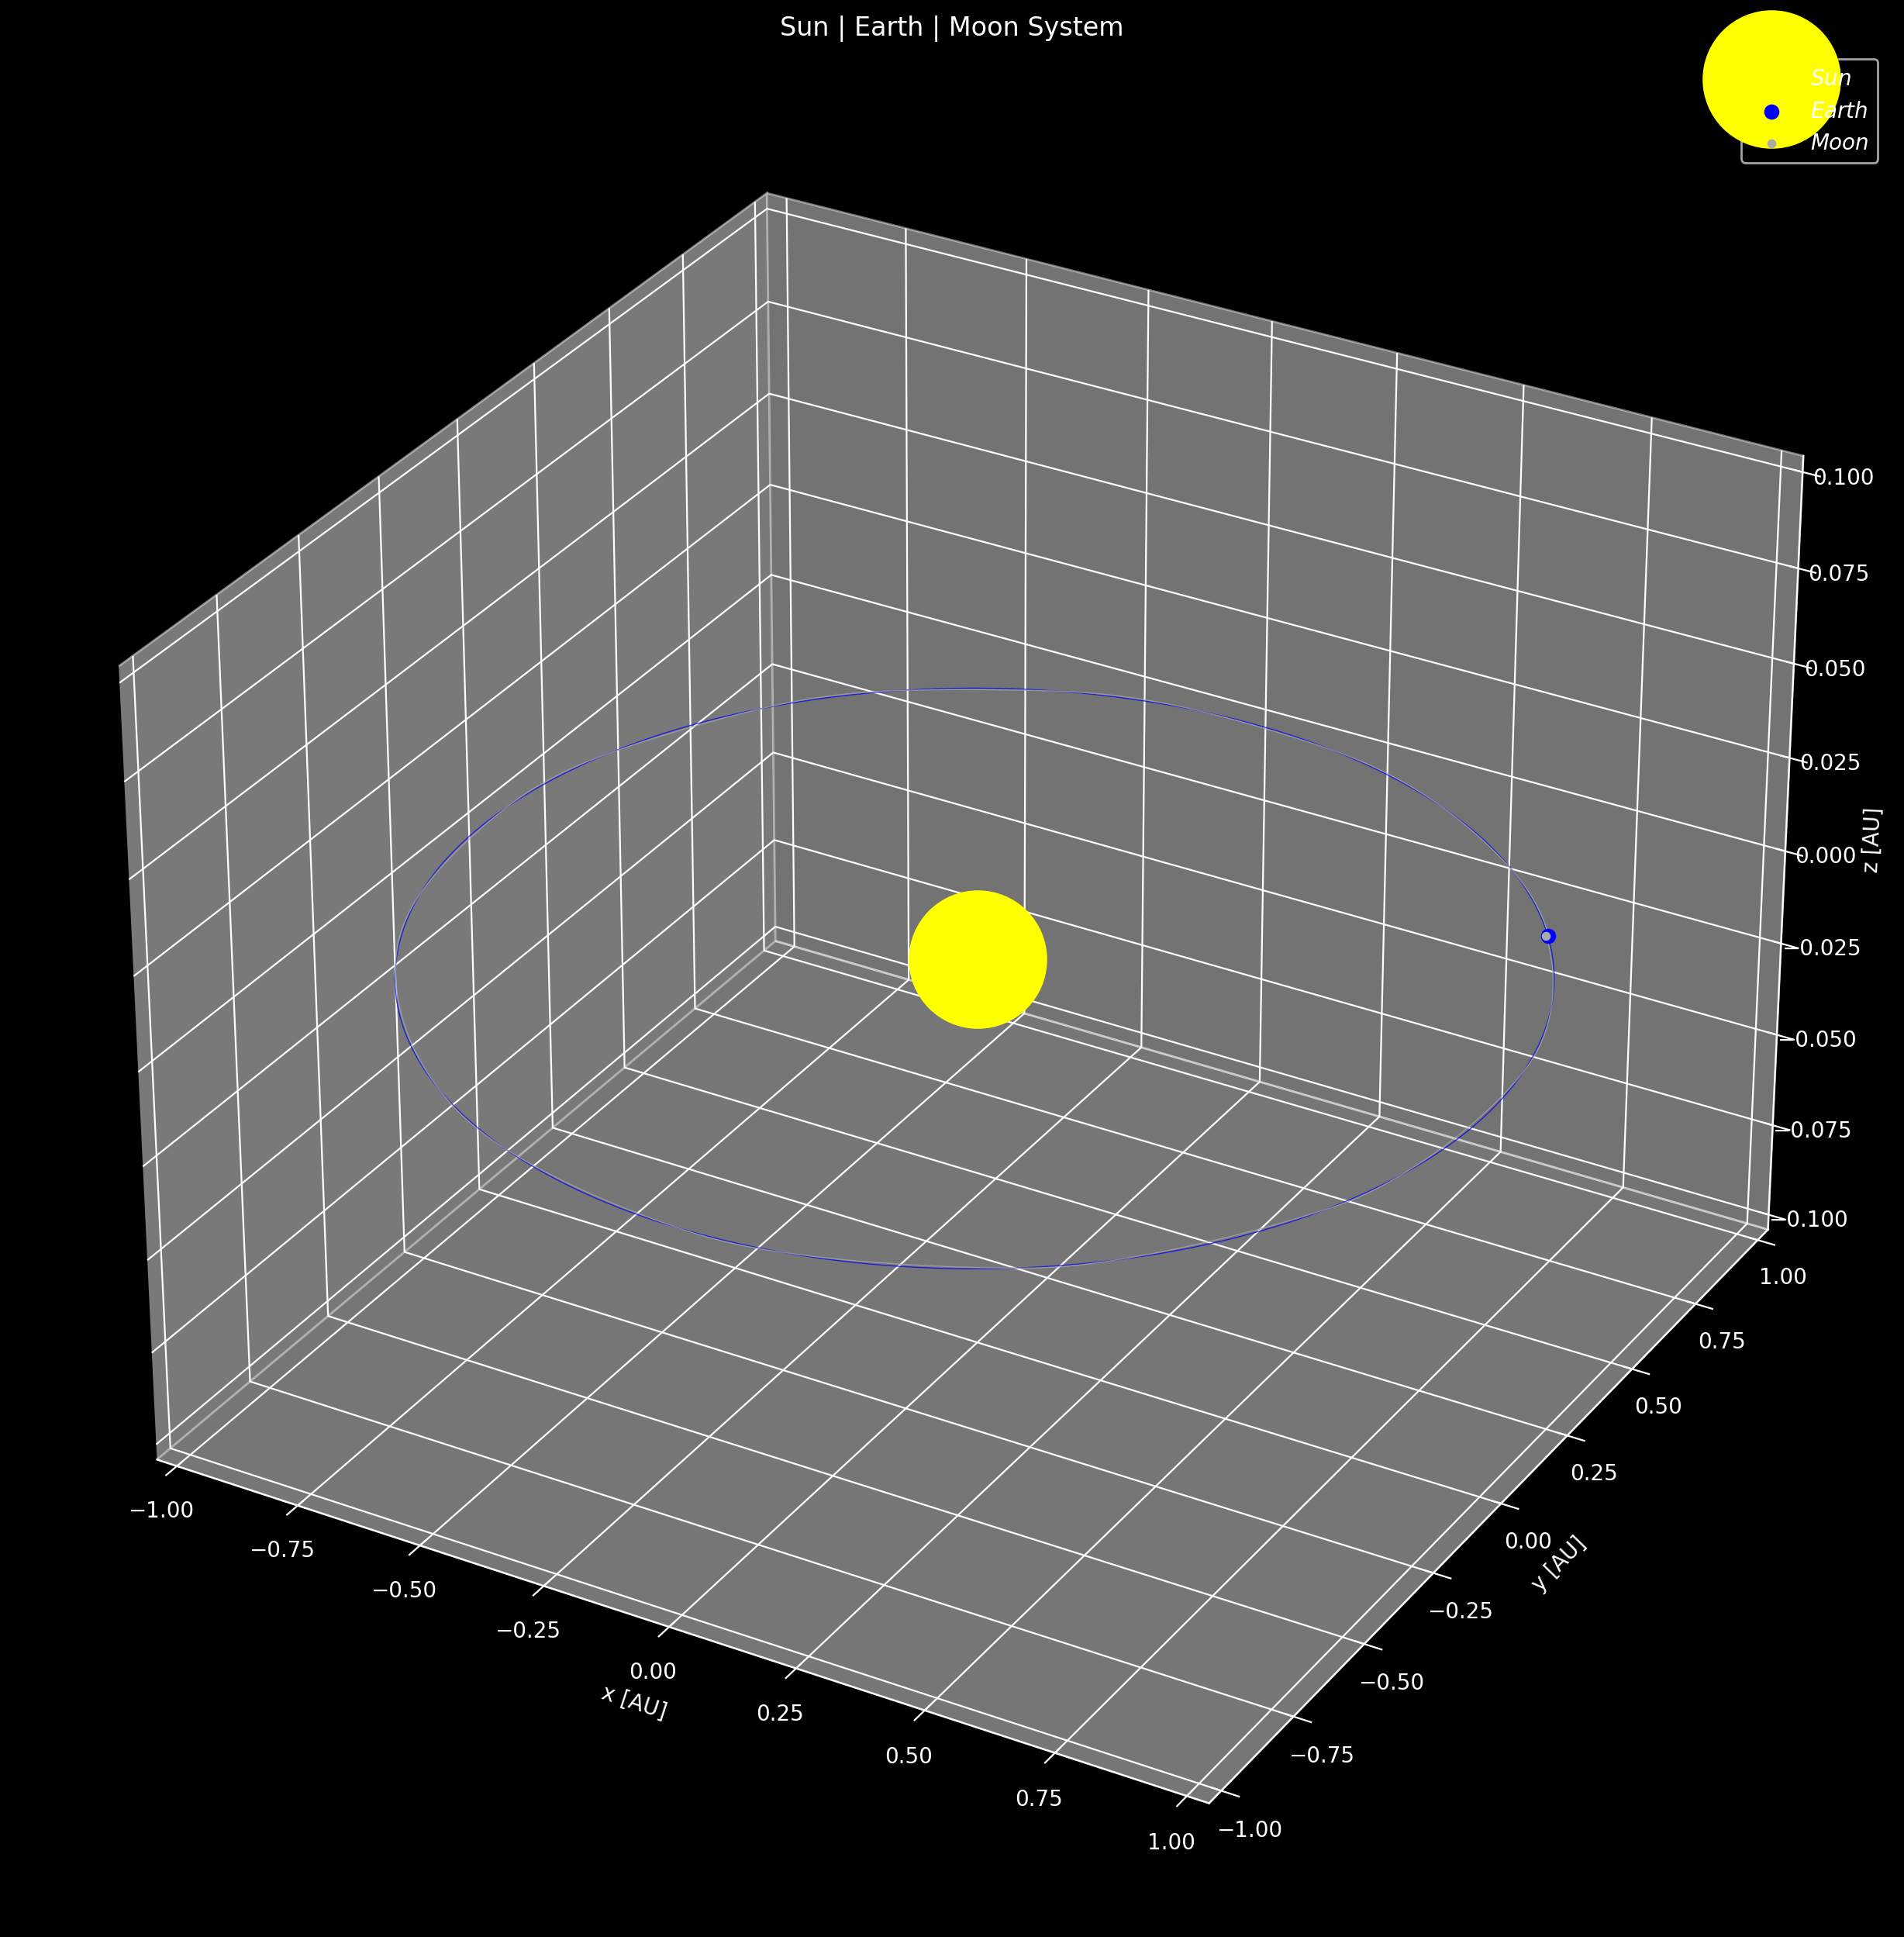

In [17]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(sun_pos[0,:], sun_pos[1,:], sun_pos[2,:],   color='yellow', lw=0.5, alpha=0.75)
ax.plot(earth_pos[0,:], earth_pos[1,:], earth_pos[2,:], color='blue', lw=0.5, alpha=0.75)
ax.plot(moon_pos[0,:], moon_pos[1,:], moon_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(sun_pos[0,-1], sun_pos[1,-1], sun_pos[2,-1], color='yellow', s=10 * sun_radius / smallest_radius, label=r'$Sun$')
ax.scatter(earth_pos[0,-1], earth_pos[1,-1], earth_pos[2,-1], color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1], moon_pos[1,-1], moon_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'$Moon$')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0.1,0.1)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Sun | Earth | Moon System')
plt.legend()
plt.savefig('plots/P2a_plot.png')

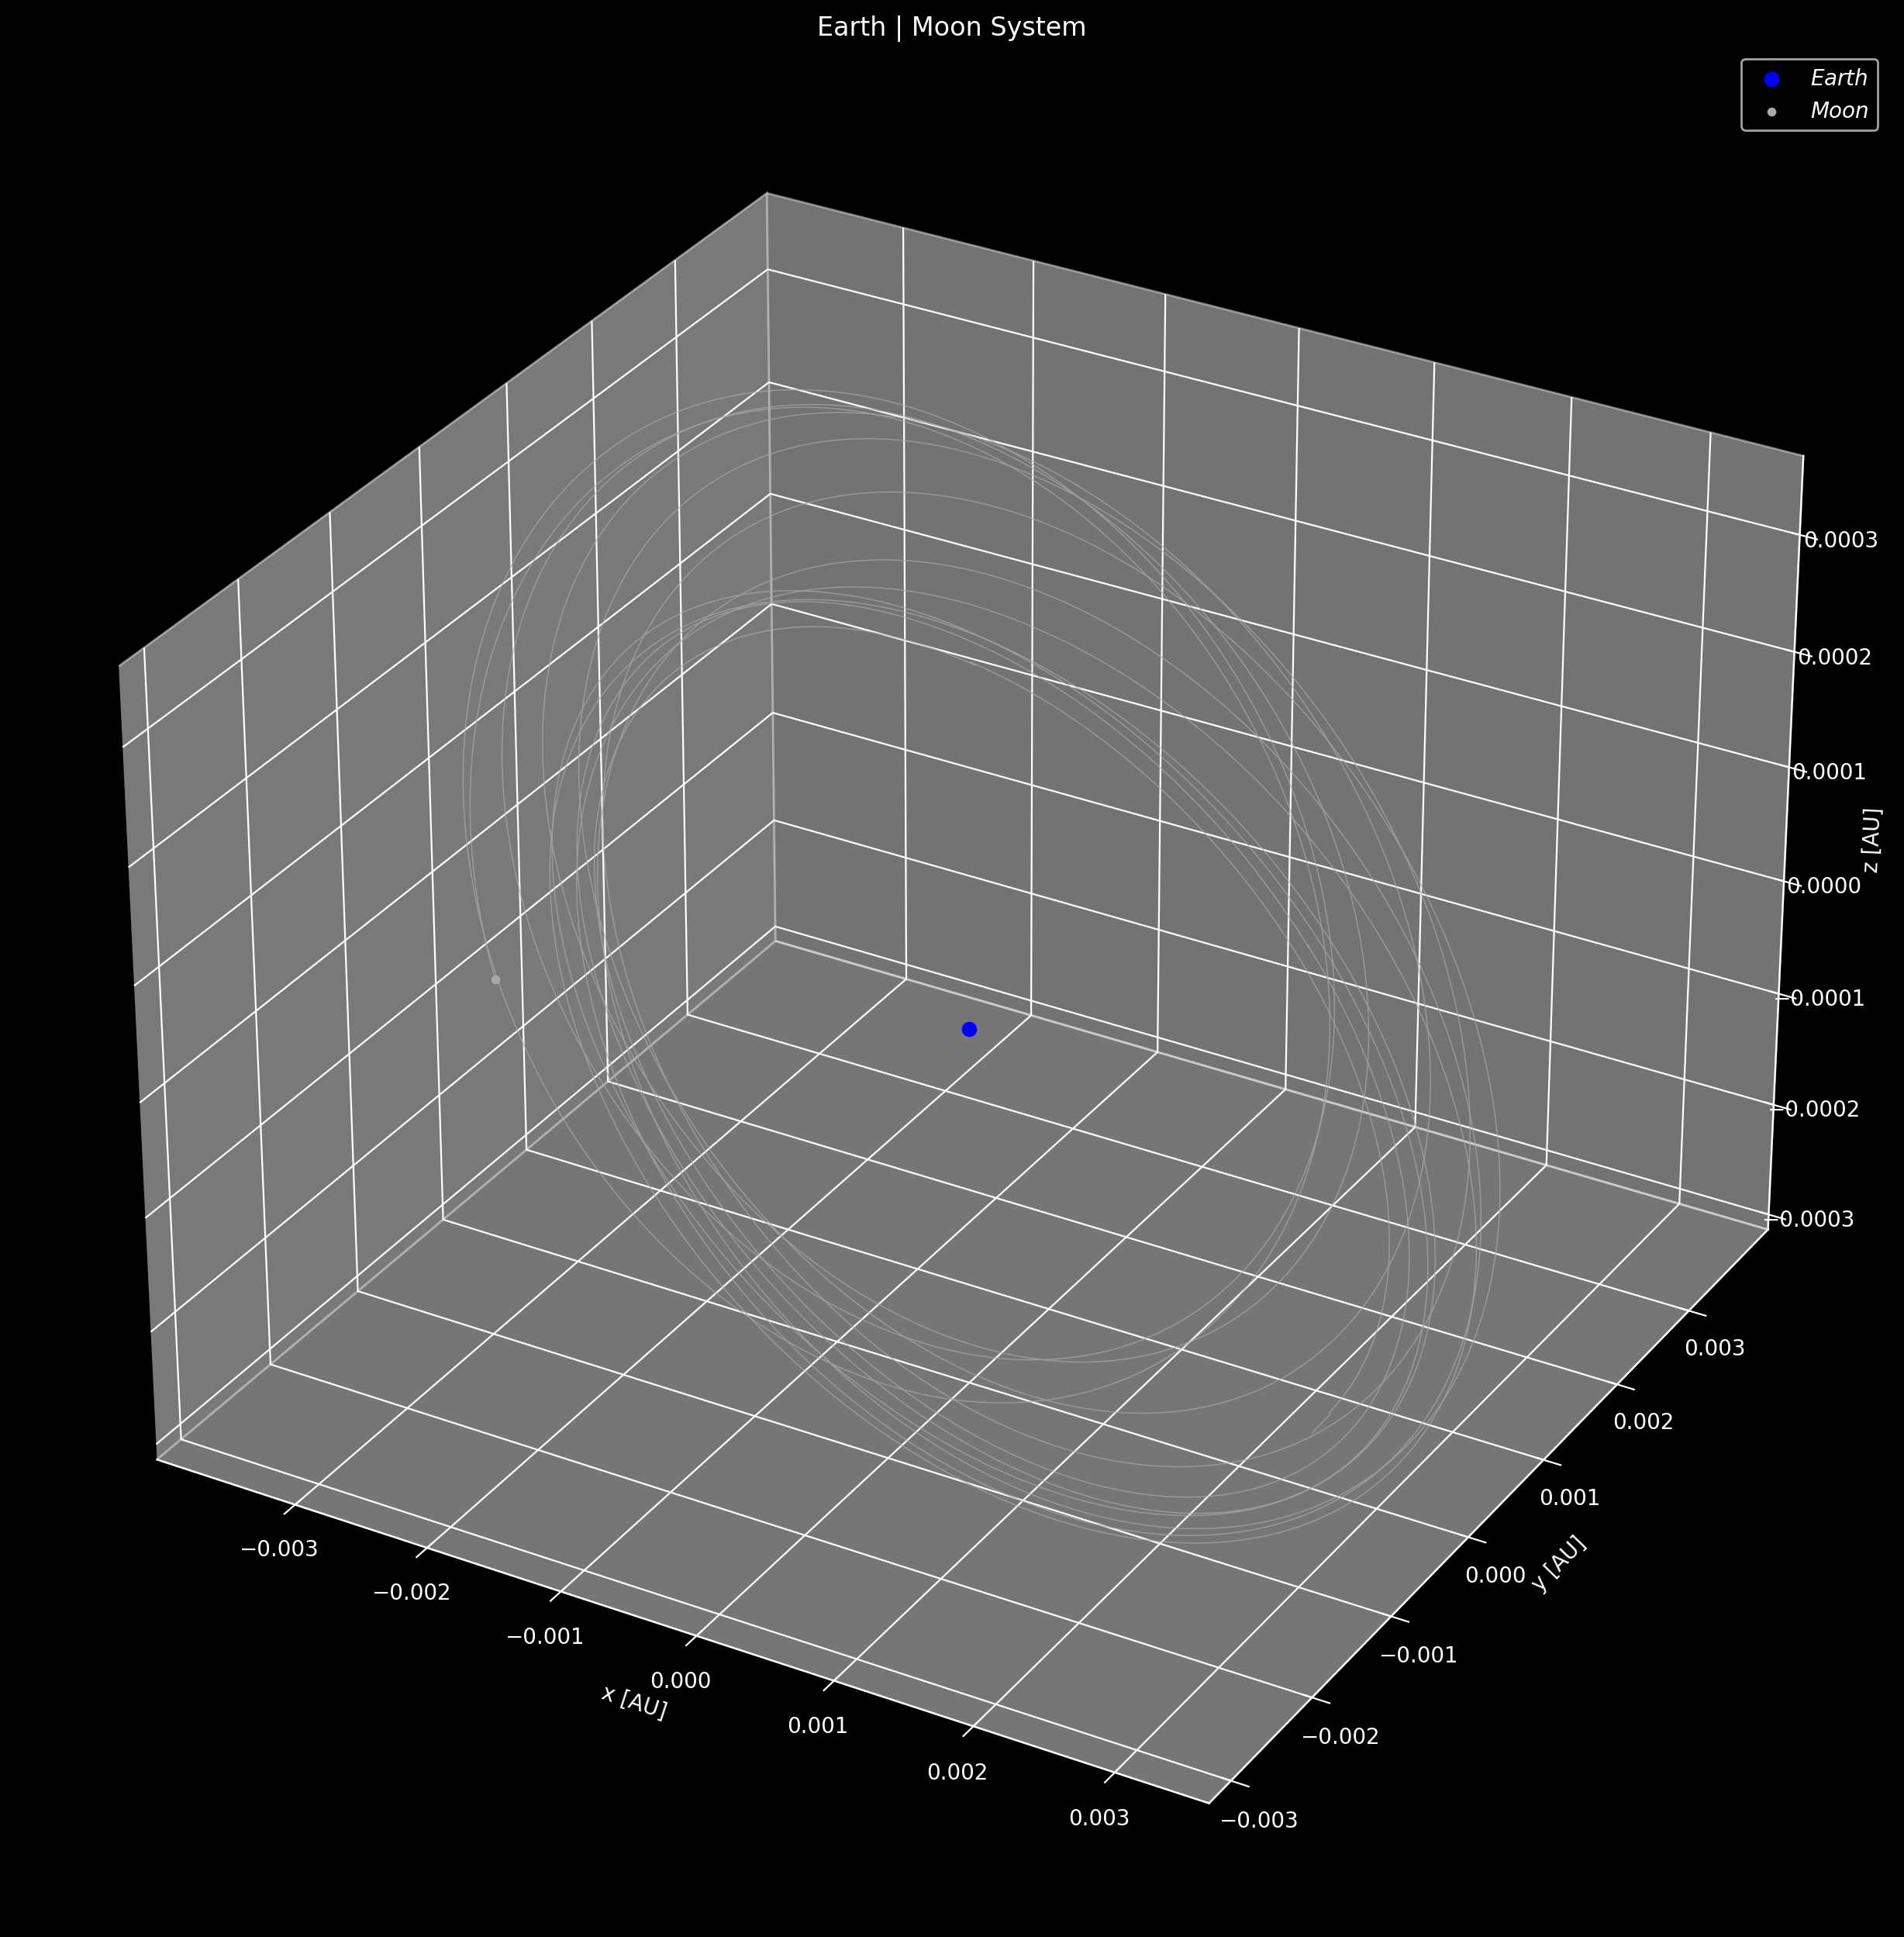

In [18]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(moon_pos[0,:] - earth_pos[0,:], moon_pos[1,:] - earth_pos[1,:], moon_pos[2,:] - earth_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(0, 0, 0, color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1] - earth_pos[0,-1], moon_pos[1,-1] - earth_pos[1,-1], moon_pos[2,-1] - earth_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'$Moon$')

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Earth | Moon System')

plt.legend()
plt.savefig('plots/P2b_plot.png')

In [19]:
moon_mass = earth_mass

def rhs(t, state, m0=sun_mass, m1=earth_mass, m2=moon_mass):
    r0, r1, r2, dr0, dr1, dr2 = np.hsplit(state, 6)
    return np.hstack((
        dr0, 
        dr1,
        dr2, 
        -m1 * (r0 - r1) / norm(r0 - r1) ** 3 - m2 * (r0 - r2) / norm(r0 - r2) ** 3,
        -m0 * (r1 - r0) / norm(r1 - r0) ** 3 - m2 * (r1 - r2) / norm(r1 - r2) ** 3,
        -m0 * (r2 - r0) / norm(r2 - r0) ** 3 - m1 * (r2 - r1) / norm(r2 - r1) ** 3
        ))

In [20]:
sun_pos = np.asarray([sun_vectors['x'], sun_vectors['y'], sun_vectors['z']]).ravel()
sun_vel = np.asarray([sun_vectors['vx'], sun_vectors['vy'], sun_vectors['vz']]).ravel()

earth_pos = np.asarray([earth_vectors['x'], earth_vectors['y'], earth_vectors['z']]).ravel()
earth_vel = np.asarray([earth_vectors['vx'], earth_vectors['vy'], earth_vectors['vz']]).ravel()

moon_pos = np.asarray([moon_vectors['x'], moon_vectors['y'], moon_vectors['z']]).ravel()
moon_vel = np.asarray([moon_vectors['vx'], moon_vectors['vy'], moon_vectors['vz']]).ravel()

state0 = np.hstack((sun_pos, earth_pos, moon_pos, sun_vel, earth_vel, moon_vel))

In [21]:
t_f = 0.5 * year
step_density = 250

sol = solve_ivp(rhs, [0, t_f], state0, t_eval=np.linspace(0, t_f, int(step_density * t_f)), rtol=1.0e-4, atol=1.0e-6, method="LSODA")
if sol.success is True:
    t, (pos, vel) = sol.t, np.vsplit(sol.y, 2)
    (sun_pos, earth_pos, moon_pos), (sun_vel, earth_vel, moon_vel) = np.vsplit(pos, 3), np.vsplit(vel, 3)
else:
    print('Error!', sol.message)

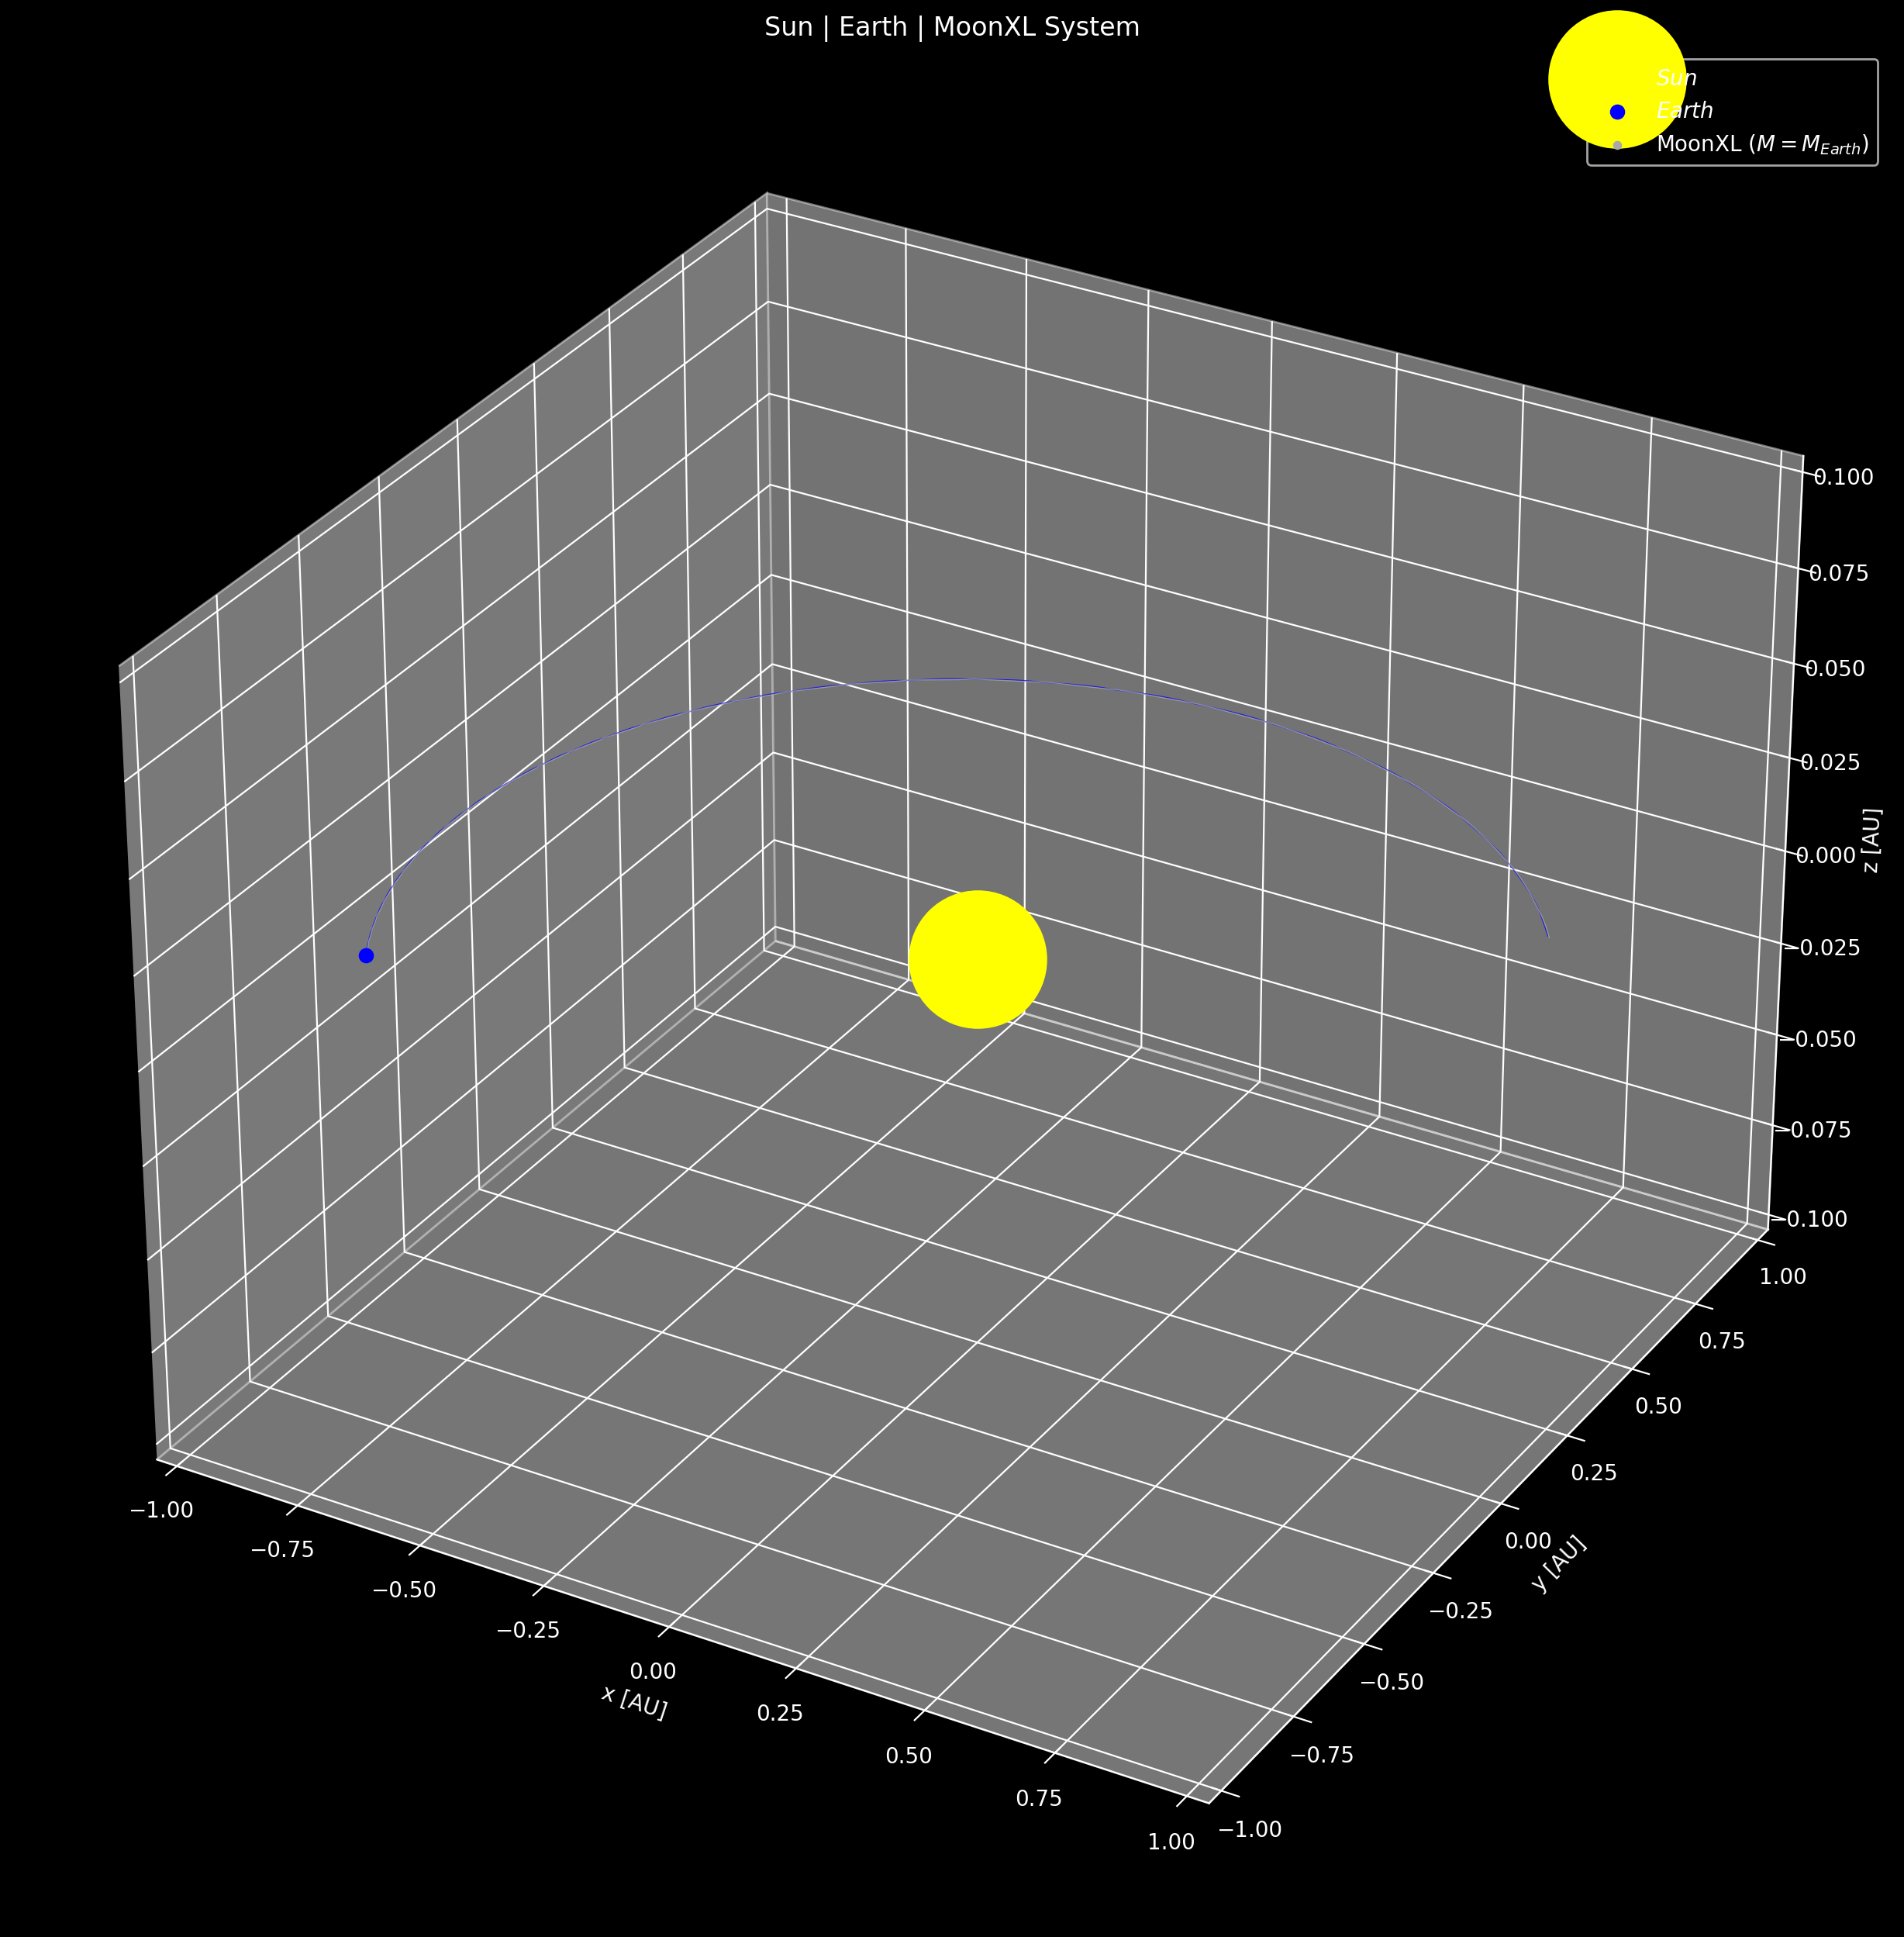

In [22]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(sun_pos[0,:], sun_pos[1,:], sun_pos[2,:],   color='yellow', lw=0.5, alpha=0.75)
ax.plot(earth_pos[0,:], earth_pos[1,:], earth_pos[2,:], color='blue', lw=0.5, alpha=0.75)
ax.plot(moon_pos[0,:], moon_pos[1,:], moon_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(sun_pos[0,-1], sun_pos[1,-1], sun_pos[2,-1], color='yellow', s=10 * sun_radius / smallest_radius, label=r'$Sun$')
ax.scatter(earth_pos[0,-1], earth_pos[1,-1], earth_pos[2,-1], color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1], moon_pos[1,-1], moon_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'MoonXL $\left(M=M_{Earth}\right)$')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0.1,0.1)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Sun | Earth | MoonXL System')
plt.legend()
plt.savefig('plots/P2c_plot.png')

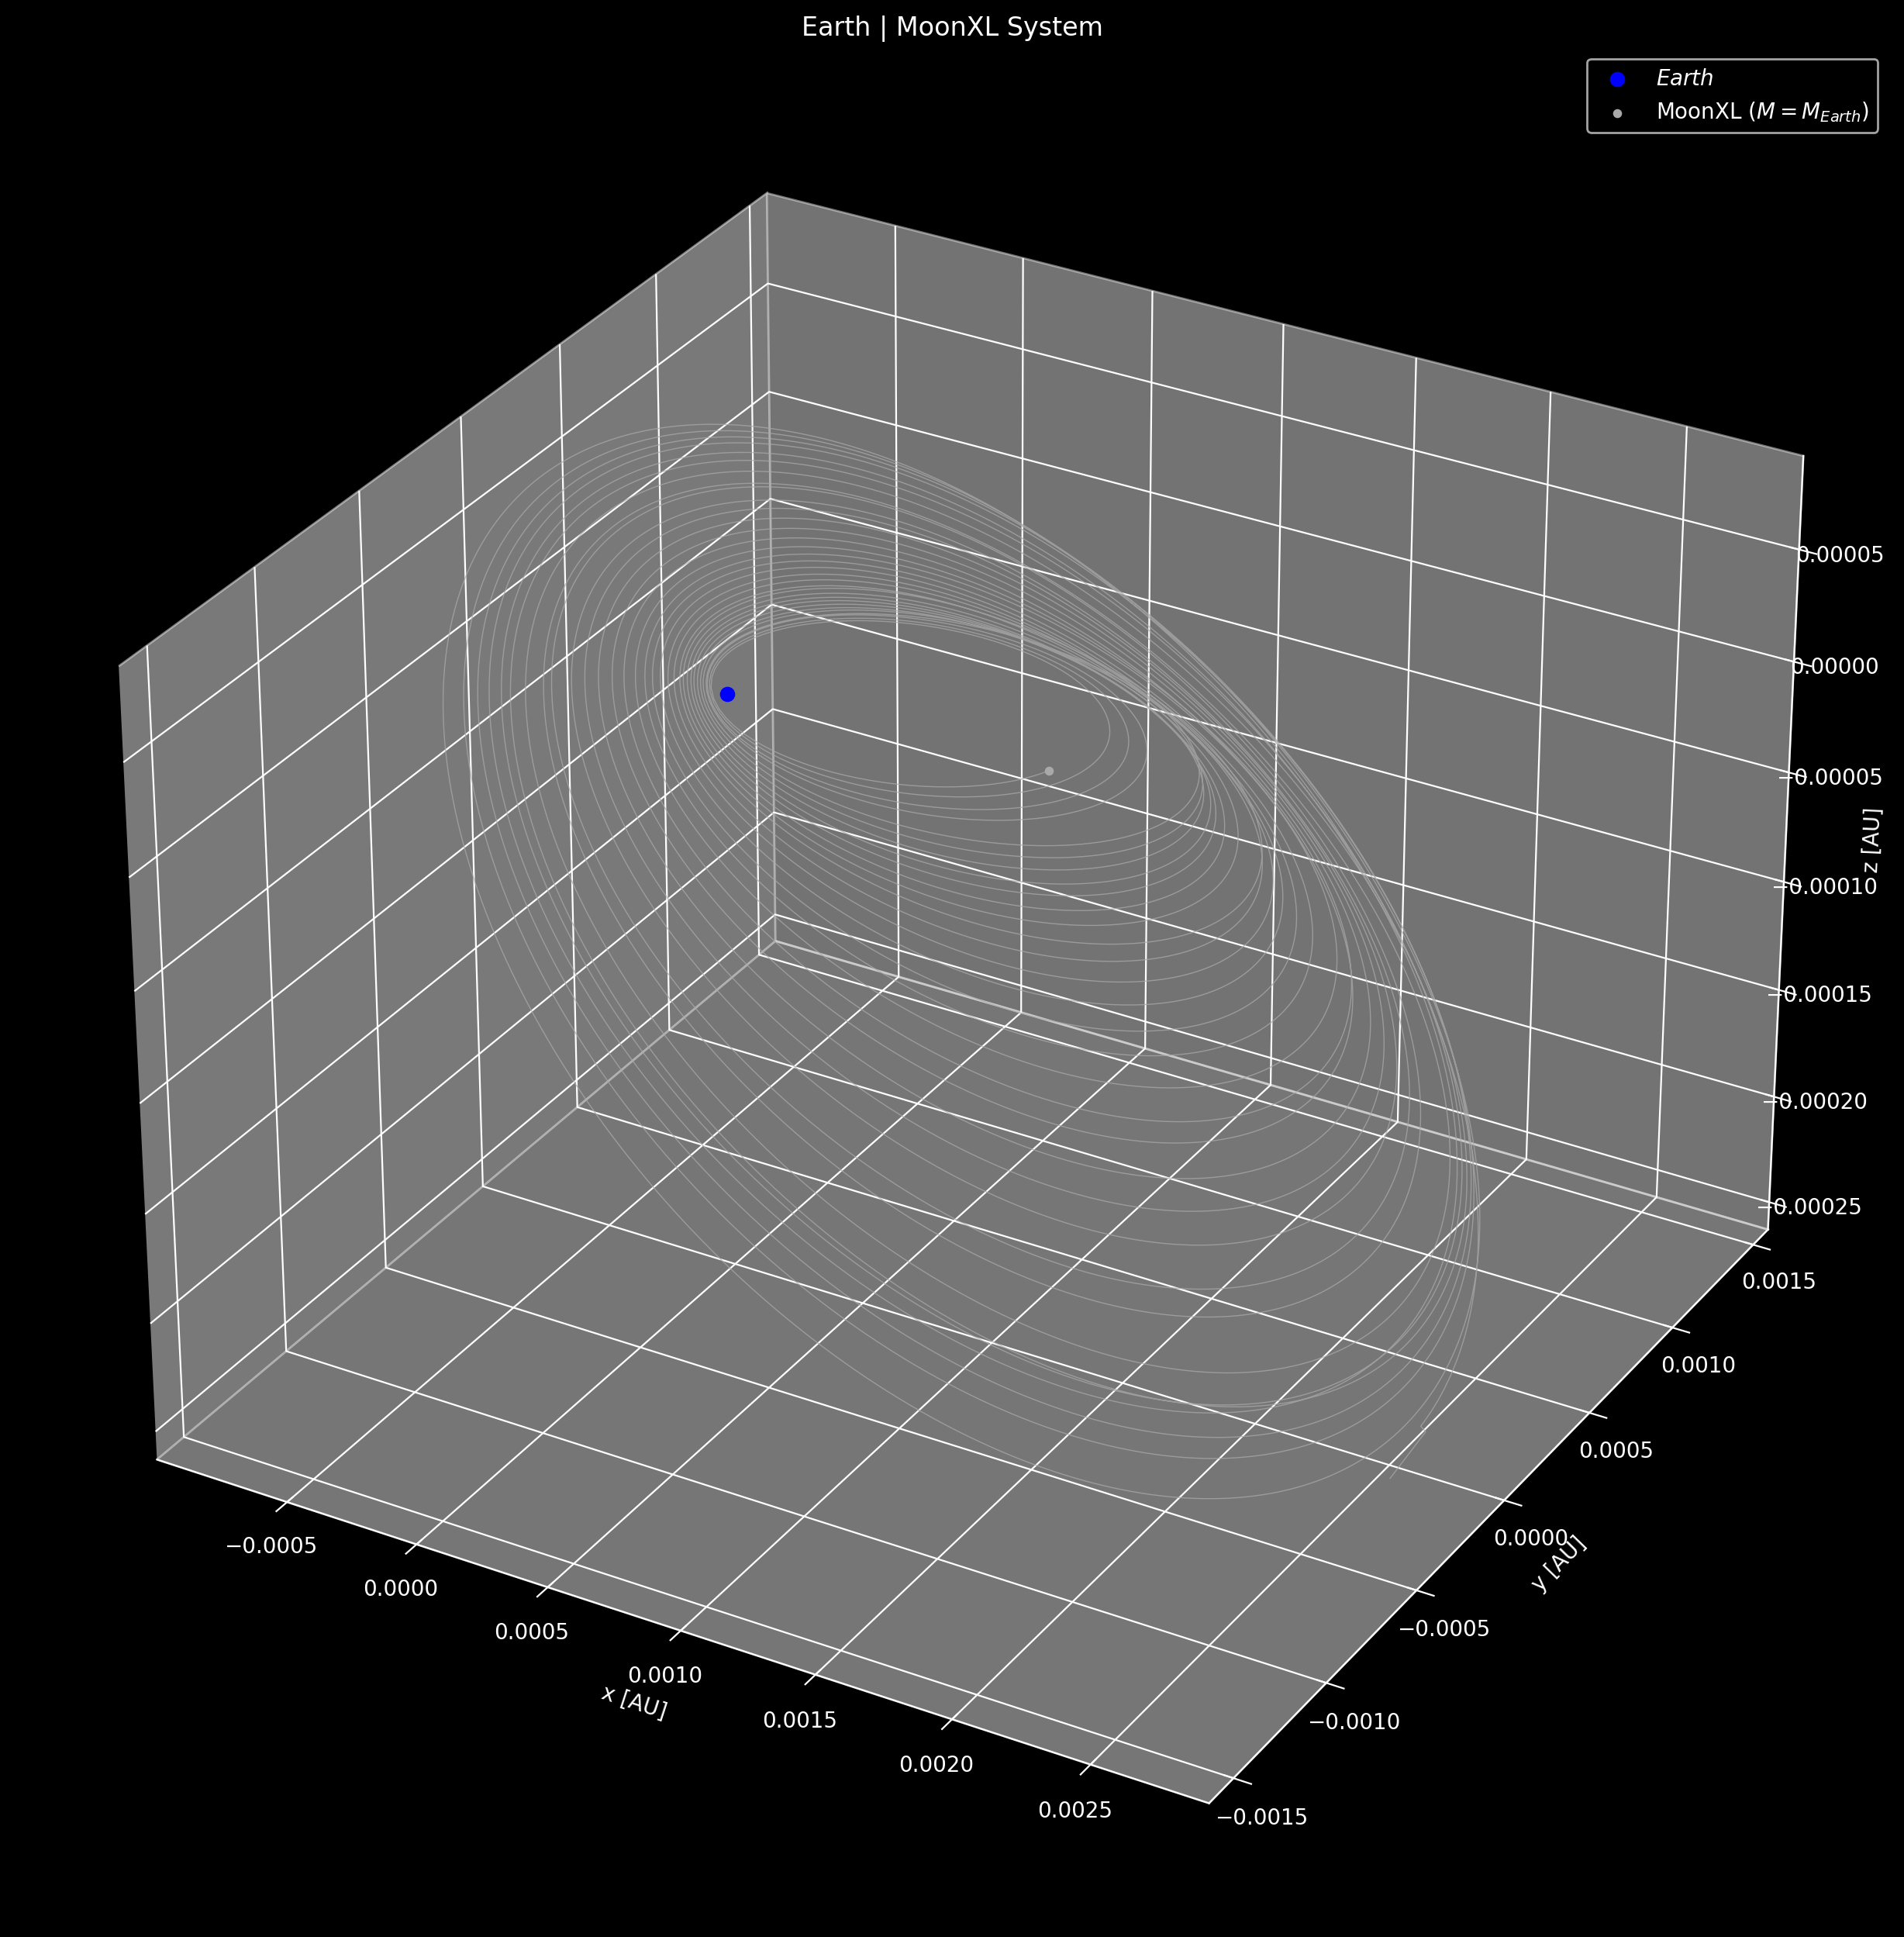

In [23]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(moon_pos[0,:] - earth_pos[0,:], moon_pos[1,:] - earth_pos[1,:], moon_pos[2,:] - earth_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(0, 0, 0, color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1] - earth_pos[0,-1], moon_pos[1,-1] - earth_pos[1,-1], moon_pos[2,-1] - earth_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'MoonXL $\left(M=M_{Earth}\right)$')

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Earth | MoonXL System')

plt.legend()
plt.savefig('plots/P2d_plot.png')

# Problem 3
## 5.7 (p.143)

Write two programs to solve the capacitor problem of Figures 5.6 and 5.7, one using the Jacobi method and one using the SOR algorithm. For a fixed accuracy (as set by the convergence test) compare the number of iterations, $N_{\text{iter}}$, that each algorithm requires as a function of the number of grid elements, $L$. Show that for the Jacobi method $N_{\text{iter}}\sim L^2$, while with SOR $N_{\text{iter}}\sim L$.

Note that you can borrow most of the work from Lab 7, but now you have to also include the SOR algorithm in your comparisons.

### Jacobi

In [24]:
def jacobi_error_from_gridsize(n, **kwargs):
    PDE = -laplacian_2d(n)
    
    # Boundary Conditions
    b = np.zeros_like(PDE[:,1])
    b[:n-2] = np.repeat(-V, n - 2)
    b[-n+2:] = np.repeat(V, n - 2)
    
    x_init = np.zeros(b.size)
    
    return jacobi_e(PDE, b, x_init, **kwargs)[1]

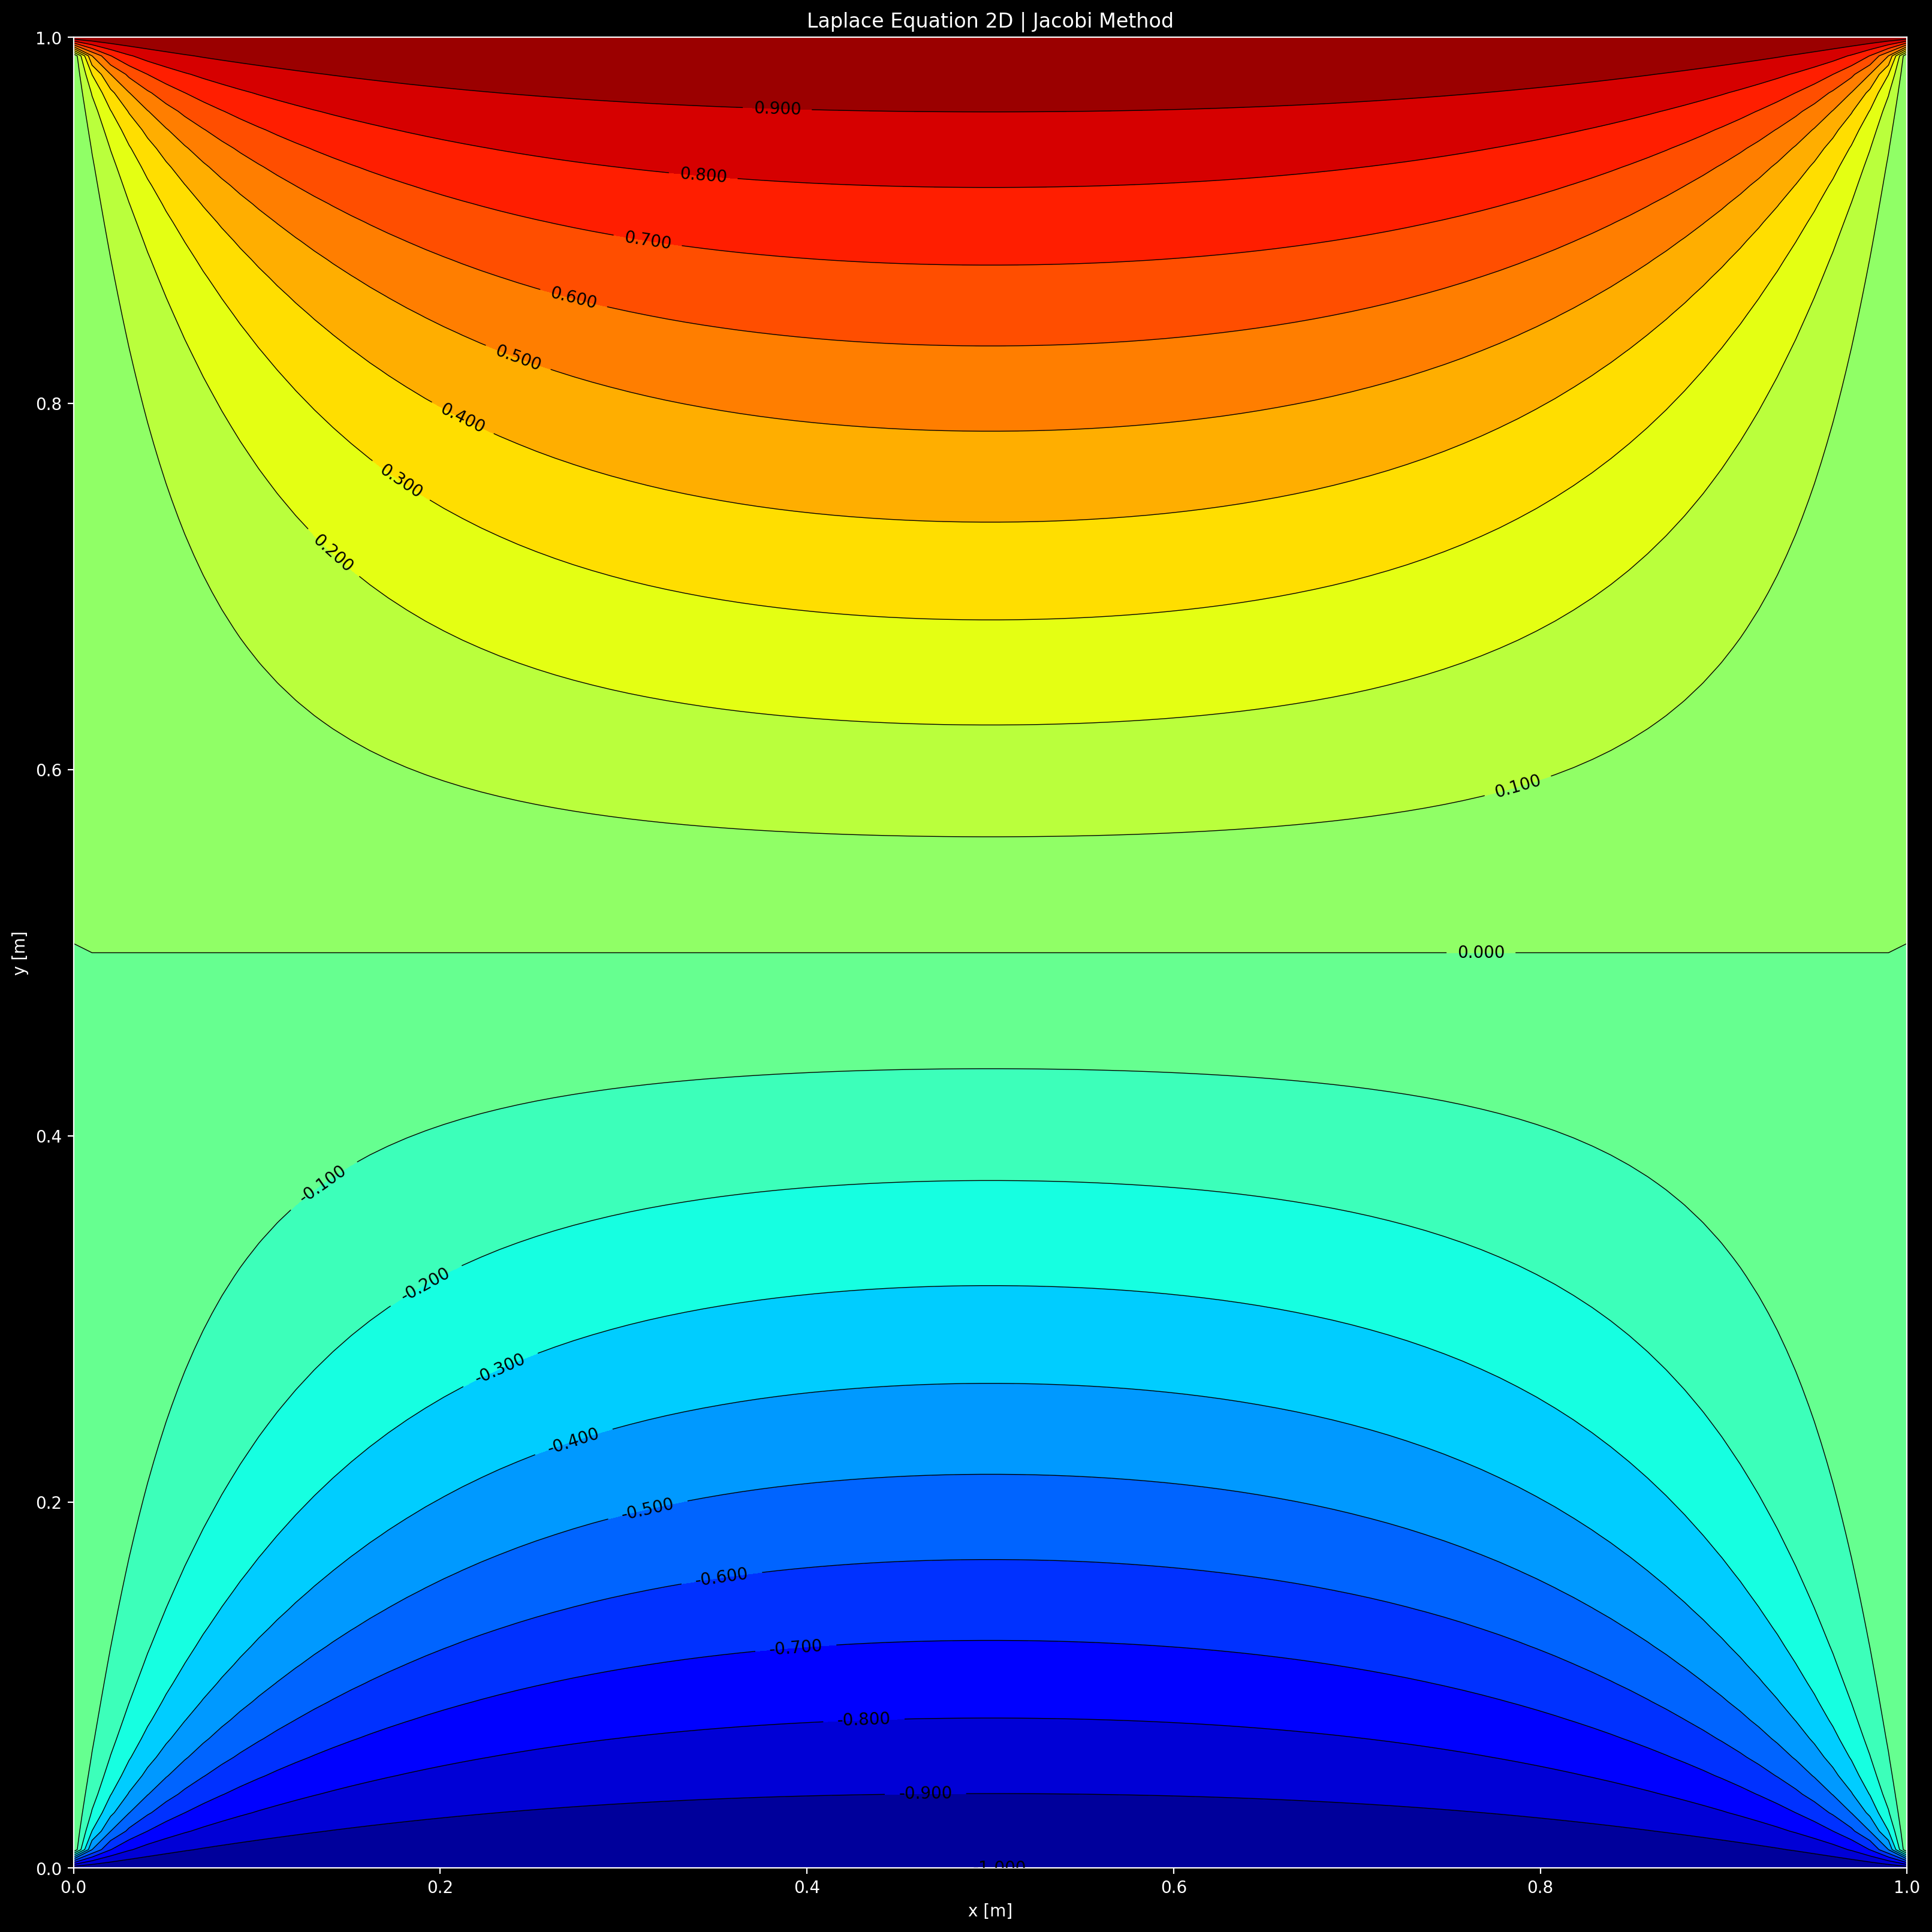

In [25]:
n = 100
V = 1

PDE = -laplacian_2d(n)
    
# Boundary Conditions
b = np.zeros_like(PDE[:,1])
b[:n-2] = np.repeat(-V, n - 2)
b[-n+2:] = np.repeat(V, n - 2)
    
x_init = np.zeros(b.size)
    
x, err = jacobi_e(PDE, b, x_init, min_err=0.001)
    
i = np.linspace(0, 1, n)
j = np.linspace(0, 1, n)
ii, jj = np.meshgrid(i, j, indexing='ij')

A = np.zeros((n, n))
A[0, :] = -V * np.ones(n)
A[-1, :] = V * np.ones(n)
A[1:-1,1:-1] = x.reshape((n-2,n-2))

fig, ax = plt.subplots(1,1, figsize=(16,16), dpi=200, constrained_layout=True)
contour = ax.contourf(jj, ii, A, levels=20, linestyles = 'solid', cmap=plt.cm.jet)
contour_lines = ax.contour(jj, ii, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
contour_line_labels = plt.clabel(contour_lines, colors='k')

ax.set_title('Laplace Equation 2D | Jacobi Method')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig(f'plots/P3_jacobi_plot.png')

### SOR

In [26]:
def sor_error_from_gridsize(n, **kwargs):
    PDE = -laplacian_2d(n)
    
    # Boundary Conditions
    b = np.zeros_like(PDE[:,1])
    b[:n-2] = np.repeat(-V, n - 2)
    b[-n+2:] = np.repeat(V, n - 2)
    
    x_init = np.zeros(b.size)
    return sor_e(PDE, b, x_init, **kwargs)[1]

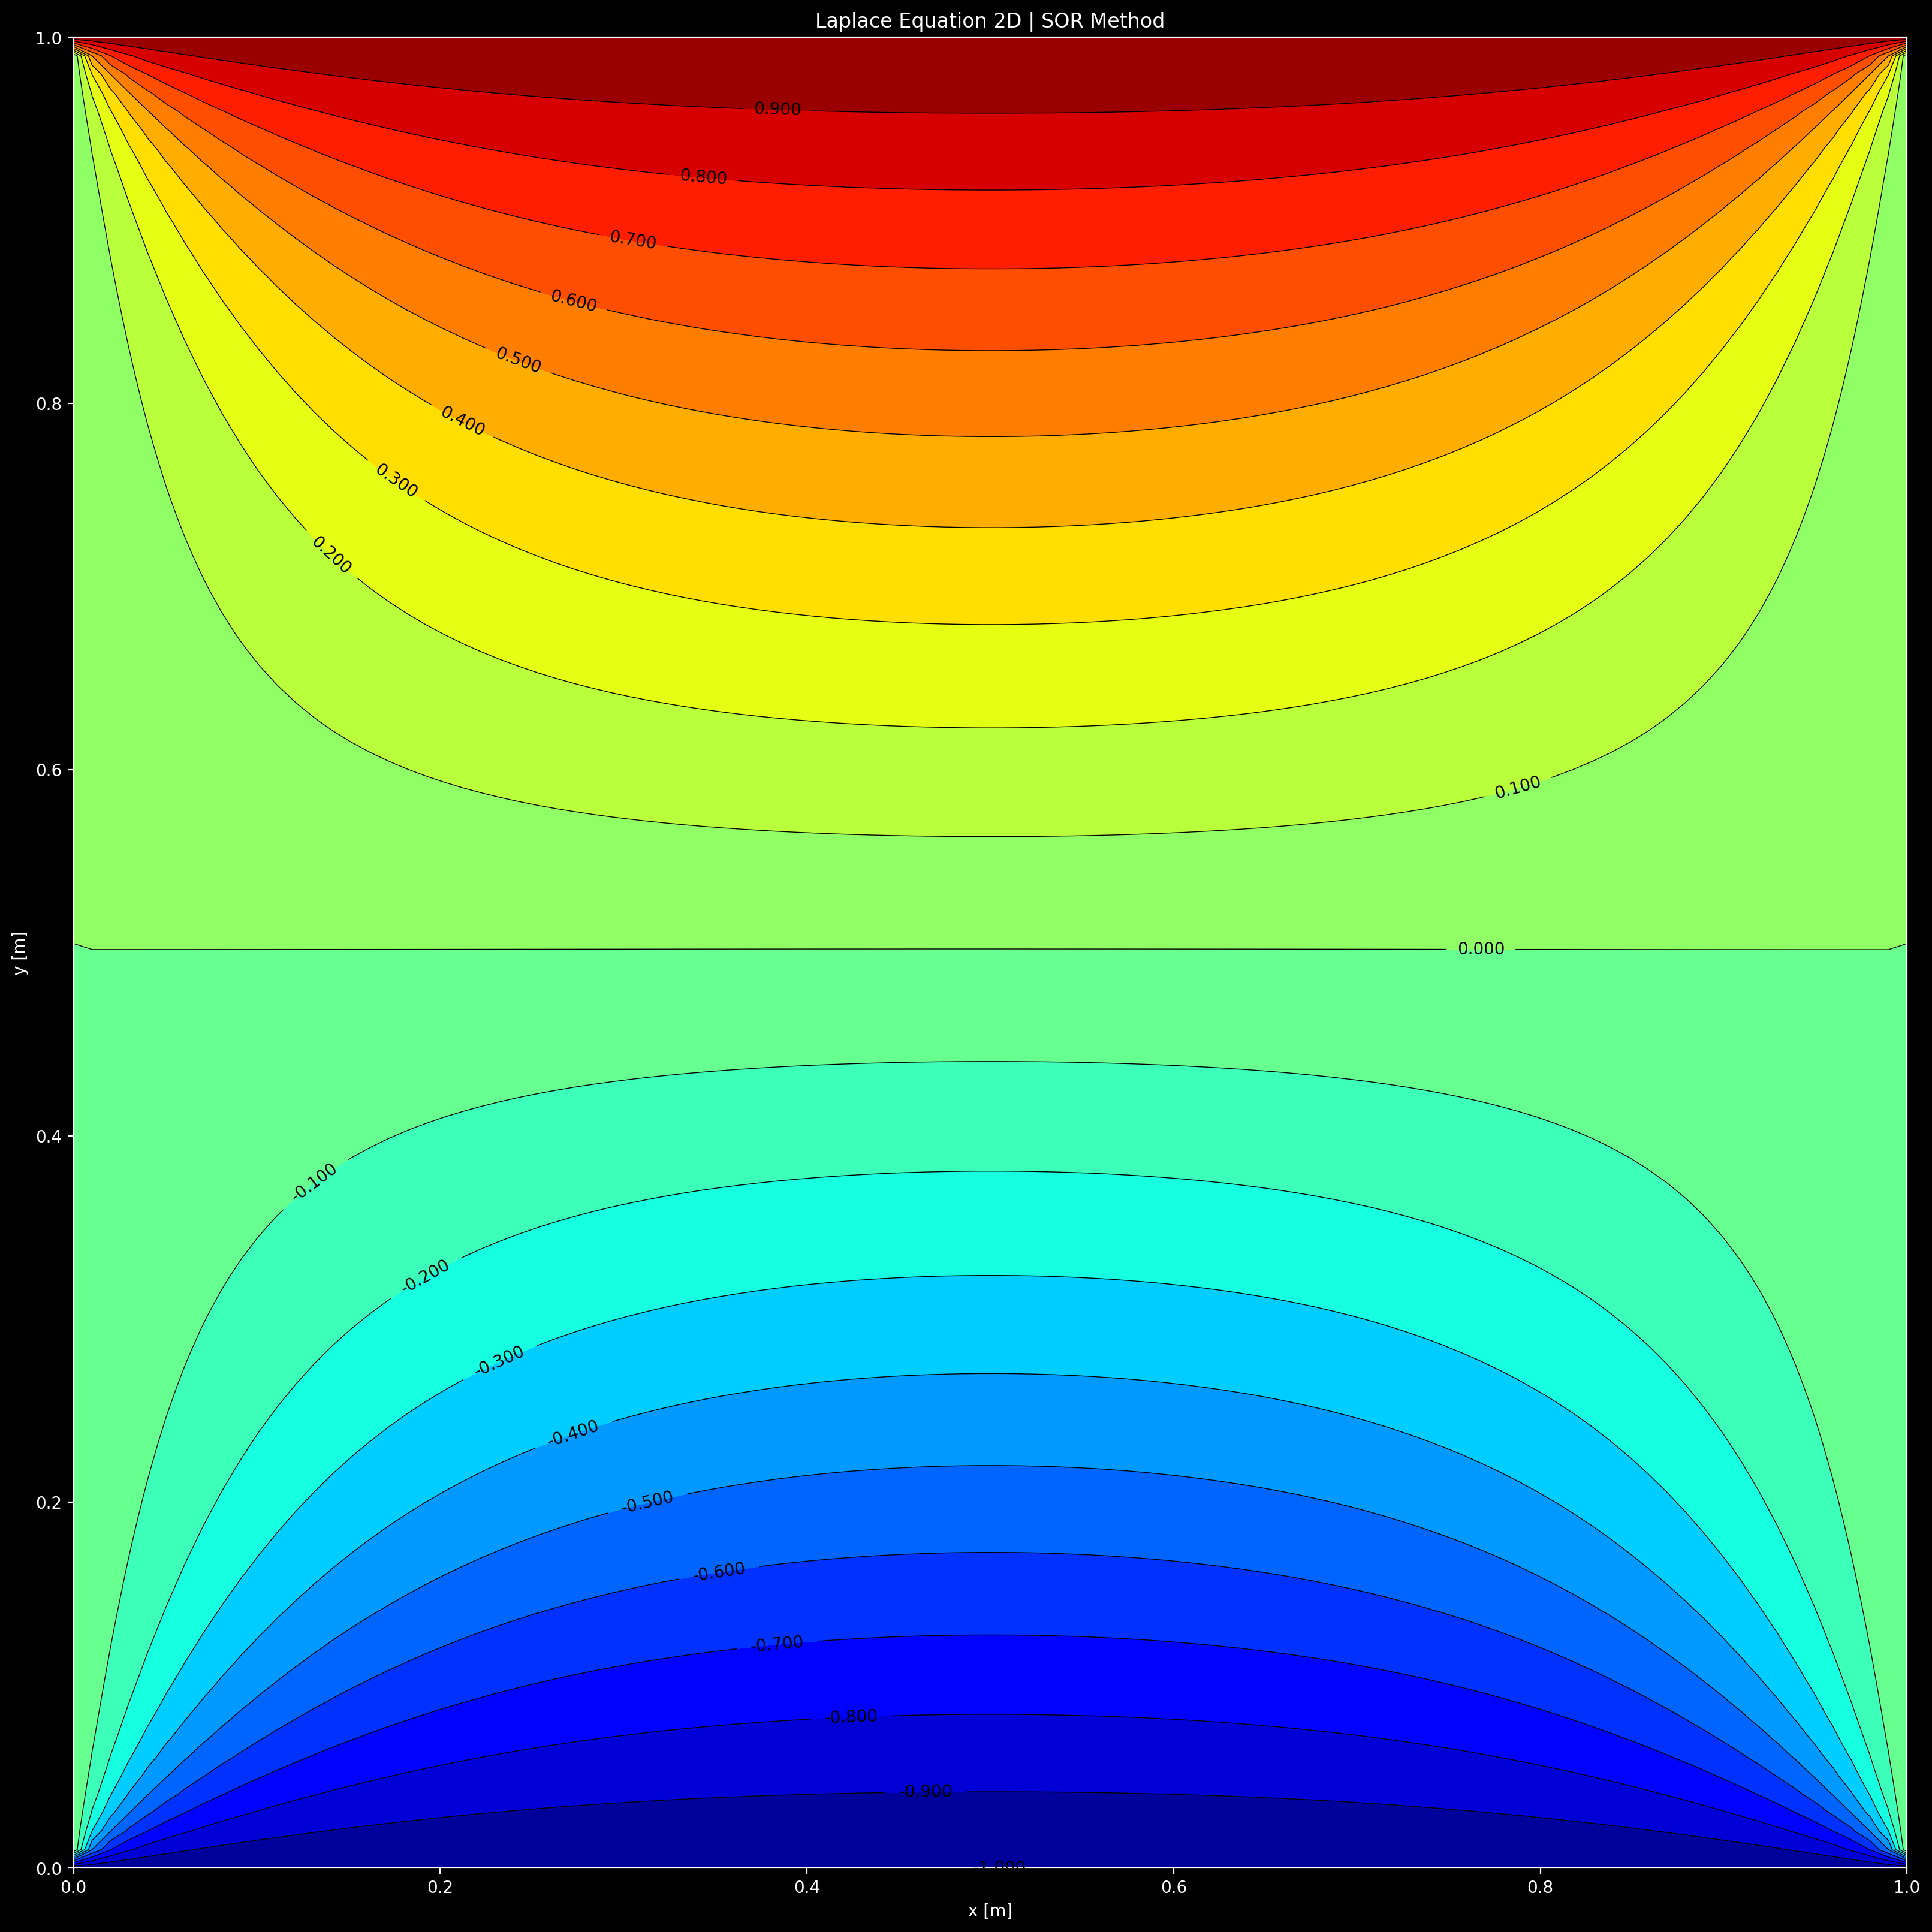

In [27]:
n = 100
V = 1

PDE = -laplacian_2d(n)
    
# Boundary Conditions
b = np.zeros_like(PDE[:,1])
b[:n-2] = np.repeat(-V, n - 2)
b[-n+2:] = np.repeat(V, n - 2)
    
x_init = np.zeros(b.size)
    
x, err = sor_e(PDE, b, x_init, min_err=0.001)

i = np.linspace(0, 1, n)
j = np.linspace(0, 1, n)
ii, jj = np.meshgrid(i, j, indexing='ij')

A = np.zeros((n, n))
A[0, :] = -V * np.ones(n)
A[-1, :] = V * np.ones(n)
A[1:-1,1:-1] = x.reshape((n-2,n-2))
  
fig, ax = plt.subplots(1,1, figsize=(16,16), dpi=200, constrained_layout=True)
contour = ax.contourf(jj, ii, A, levels=20, linestyles = 'solid', cmap=plt.cm.jet)
contour_lines = ax.contour(jj, ii, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
contour_line_labels = plt.clabel(contour_lines, colors='k')

ax.set_title('Laplace Equation 2D | SOR Method')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig(f'plots/P3_sor_plot.png')

### Iterations vs. Grid Size

100%|██████████| 71/71 [05:53<00:00,  4.98s/it]


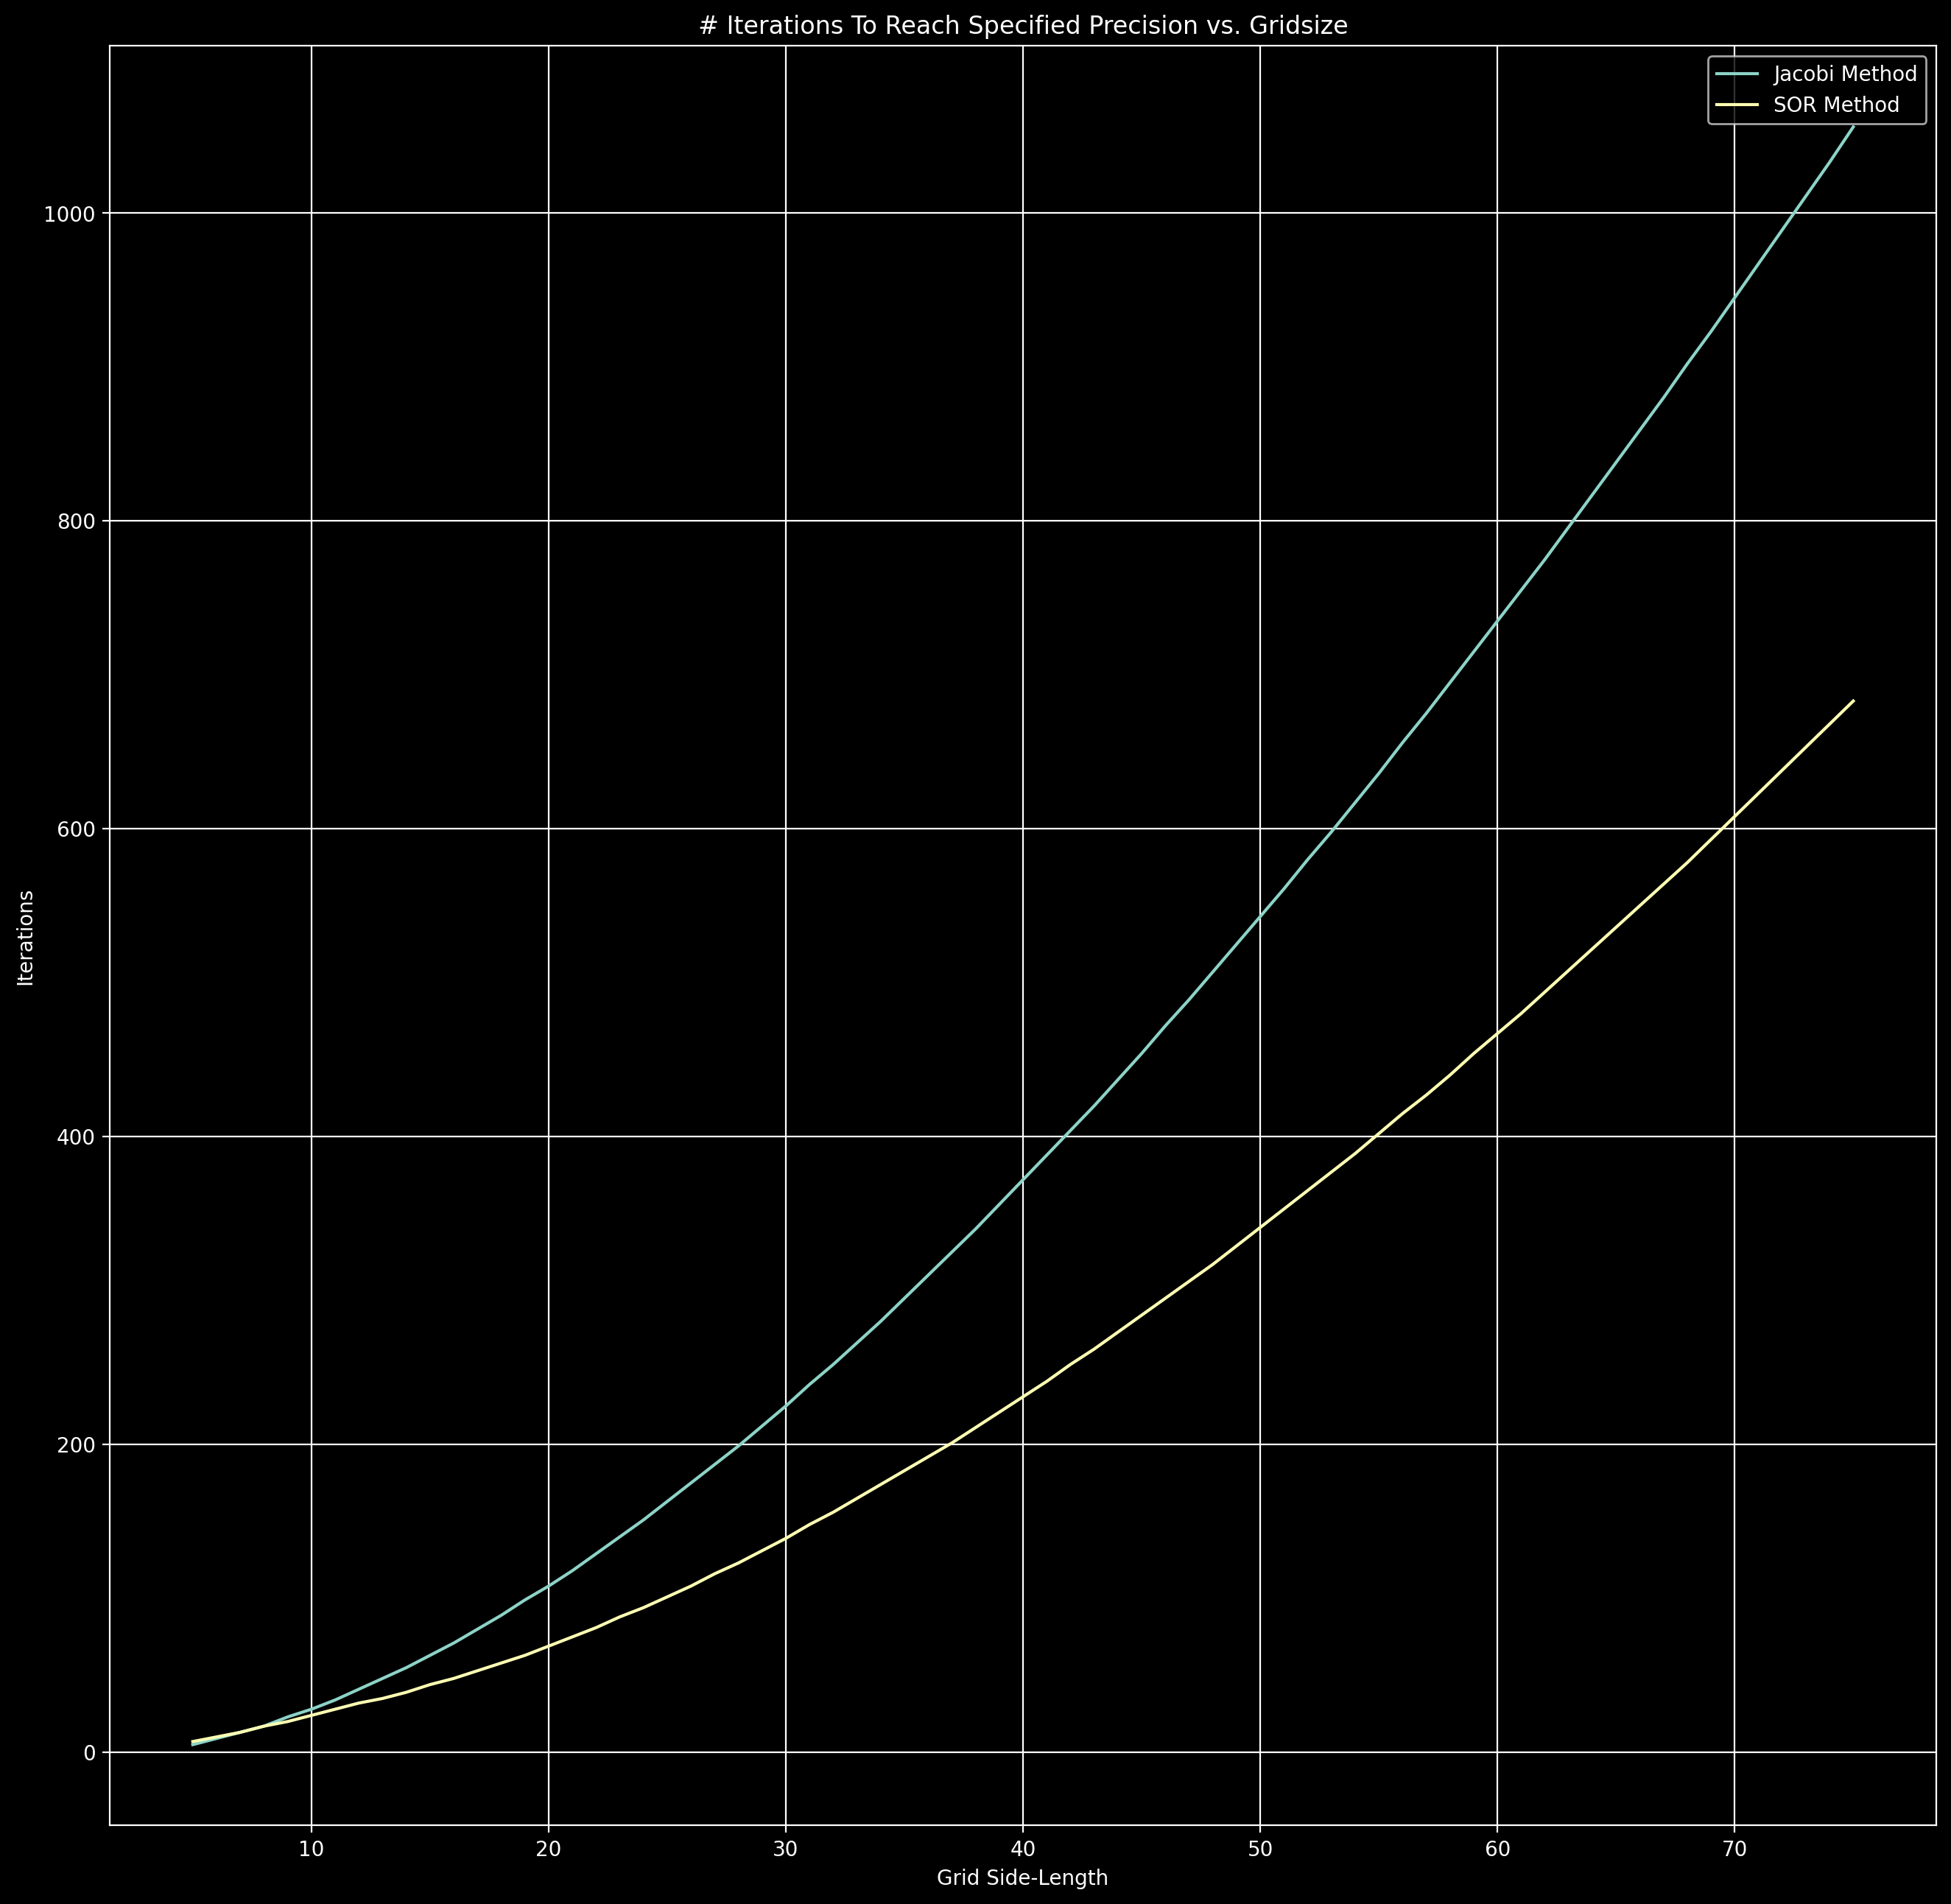

In [28]:
N = np.arange(75, 4, -1)  # Go in reverse to better diagnose if the simulation will take too long
jacobi_error = np.zeros_like(N)
sor_error = np.zeros_like(N)
V = 1

for idx, n in enumerate(tqdm(N)):
    jacobi_error[idx] = jacobi_error_from_gridsize(n, min_err=0.005)
    sor_error[idx] = sor_error_from_gridsize(n, min_err=0.005)
    
fig, ax = plt.subplots(1,1,figsize=(16,16), dpi=200)
ax.plot(N, jacobi_error, label='Jacobi Method')
ax.plot(N, sor_error, label='SOR Method')
ax.set_xlabel('Grid Side-Length')
ax.set_ylabel('Iterations')
ax.set_title('# Iterations To Reach Specified Precision vs. Gridsize')
ax.grid()
ax.legend()
plt.savefig('plots/P3_plot.png')

# Problem 4
## 5.8 (p.147)

Extend our treatment of a point charge in a metal box to deal with the case in which the charge is located near one face of the box. Study how the equipotential contours are affected by the proximity of a grounded surface (the face of the box).

In [29]:
n = 50
dx = dy = 1.0 / n
i = np.linspace(0, 1, n)
j = np.linspace(0, 1, n)
ii, jj = np.meshgrid(i, j, indexing='ij')

In [30]:
PDE = -laplacian_2d(n)

b = np.zeros_like(PDE[:,1])
rng = np.random.default_rng()
charge = int(np.power(n, 0.3)) * n + int(np.power(n, 0.3))
b[charge] = -dx * dy * 1 * (n ** 2)

x_init = np.average(b) * np.ones_like(b)

In [31]:
x = jacobi(PDE, b, x_init)

In [32]:
A = np.zeros((n, n))
A[1:-1,1:-1] = x.reshape((n-2,n-2))

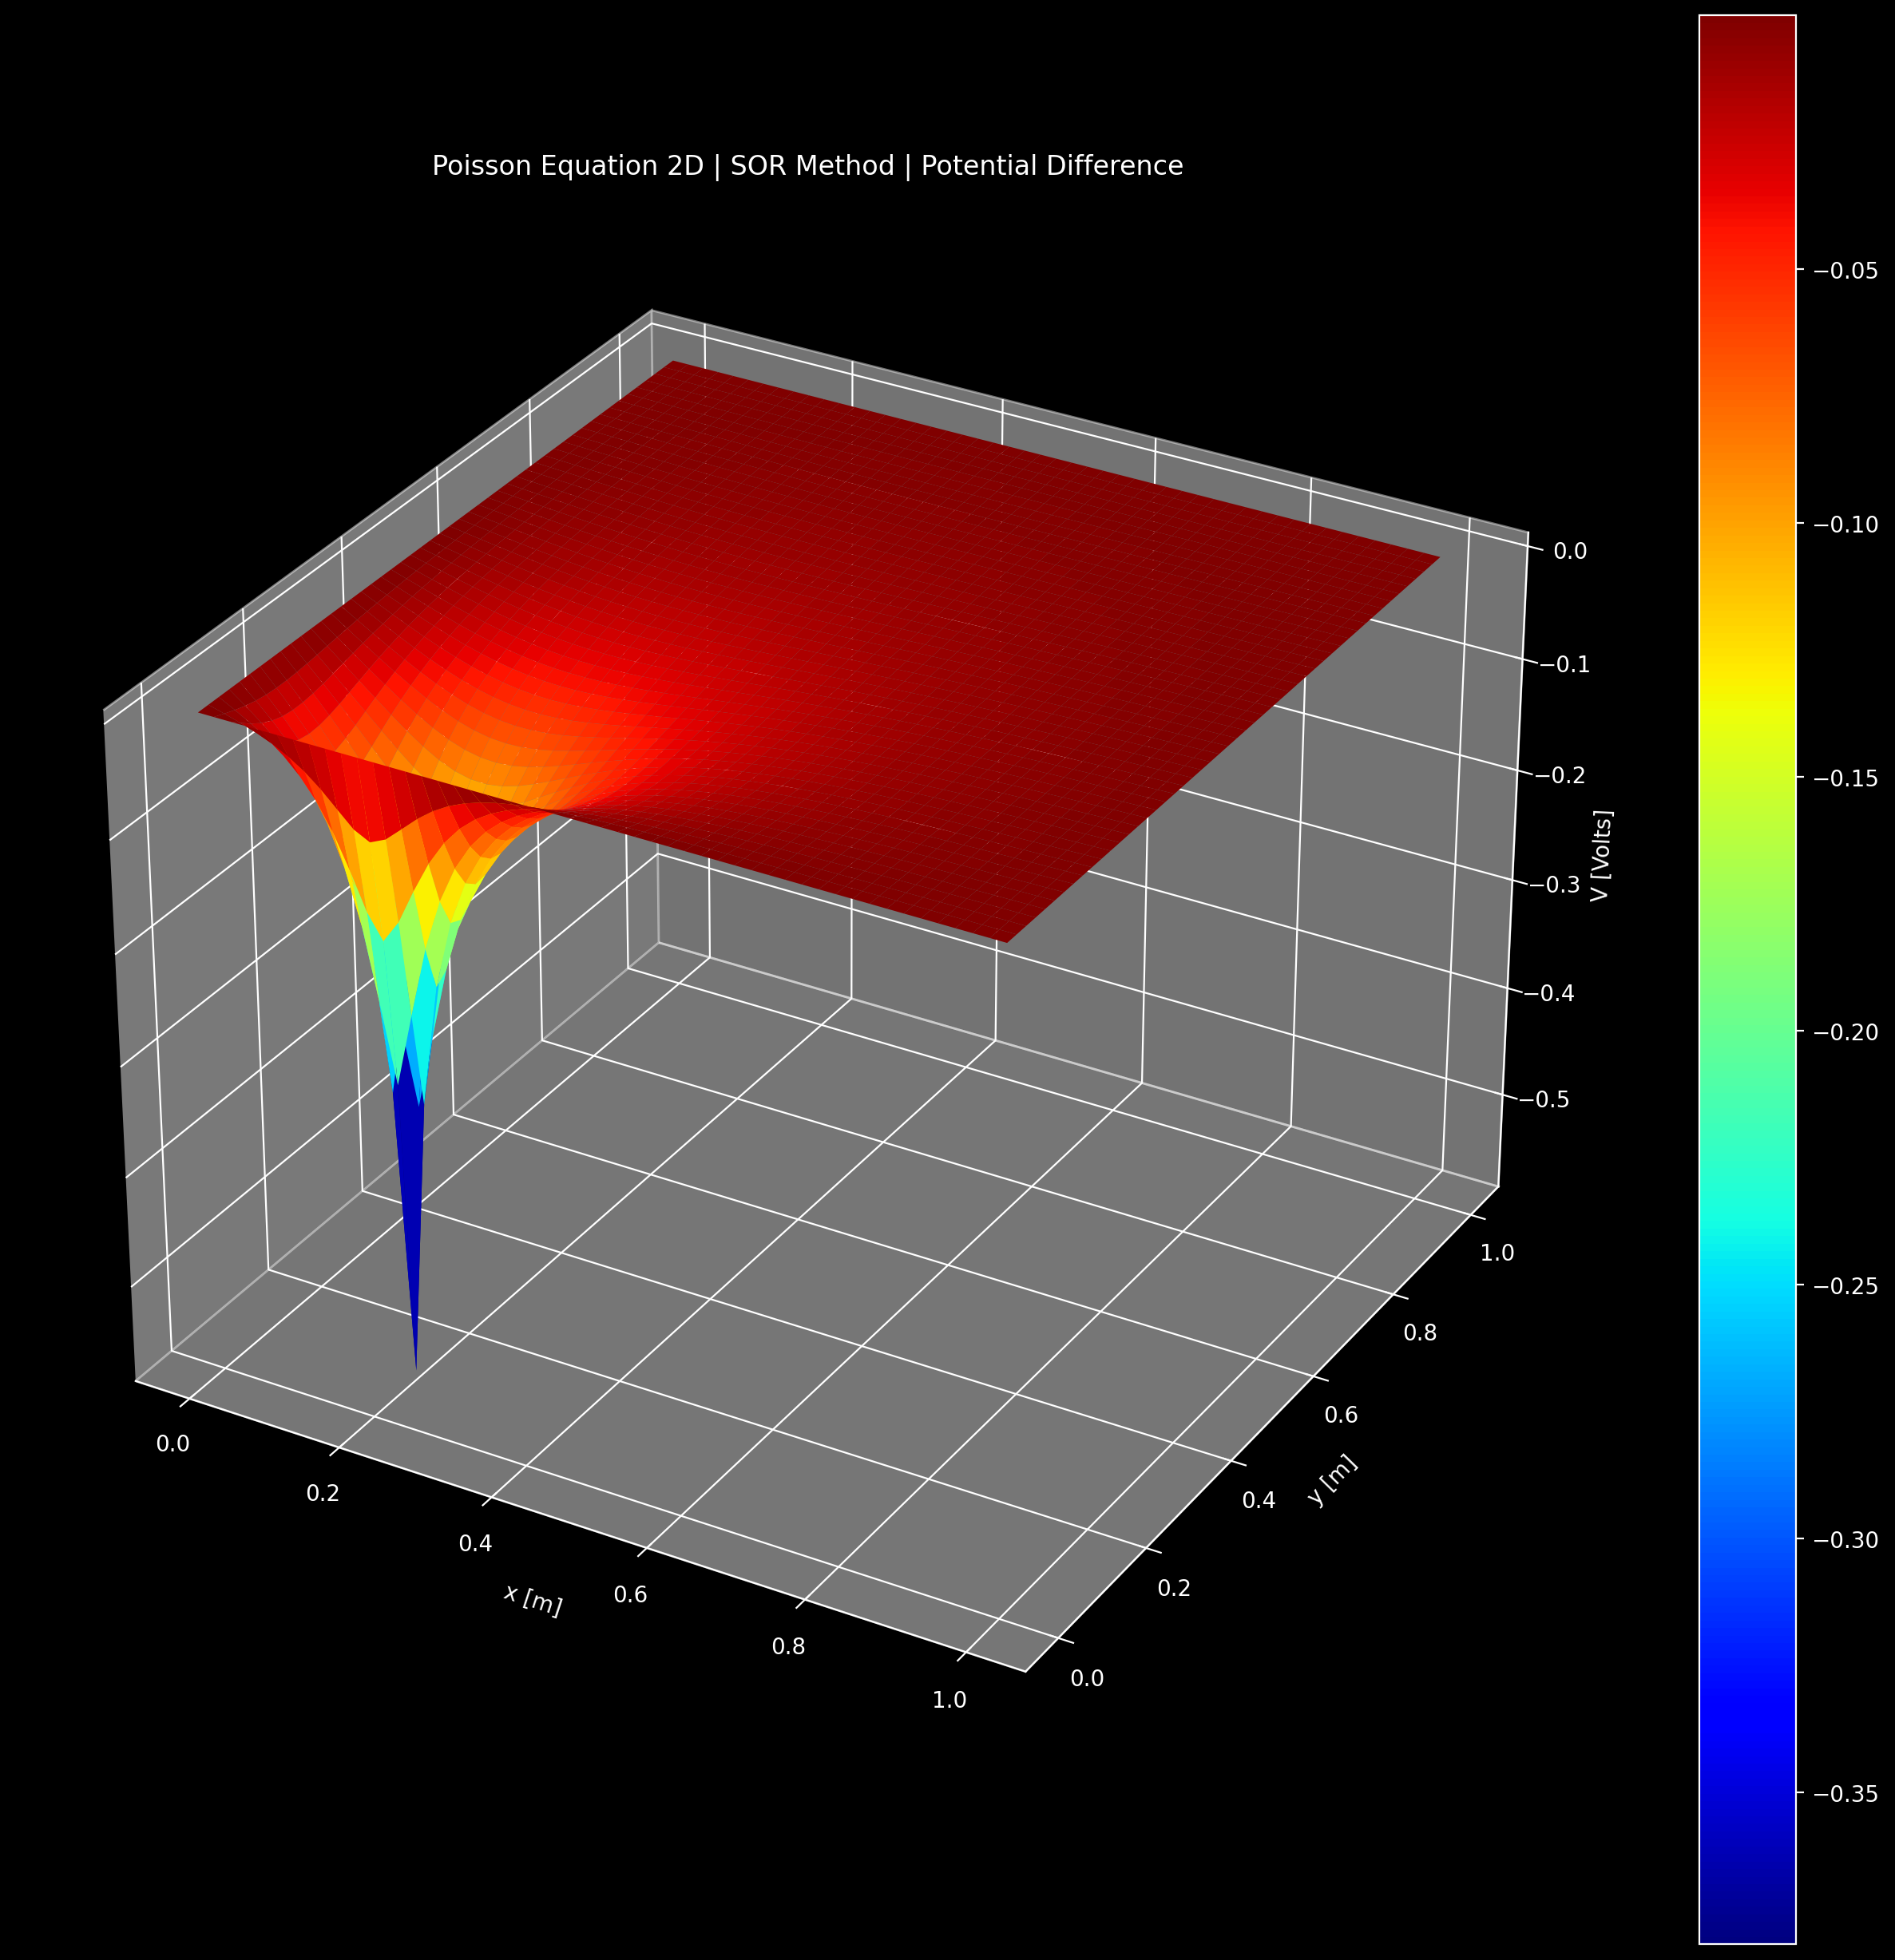

In [33]:
fig = plt.figure(figsize=(16,16),dpi=200)
ax = fig.gca(projection='3d')
surface = ax.plot_surface(jj, ii, A, cmap=plt.cm.jet, edgecolor ='none')
ax.set_title('Poisson Equation 2D | SOR Method | Potential Difference')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('V [Volts]')
fig.colorbar(surface, ax=ax) 
plt.savefig('plots/P4a_plot.png')

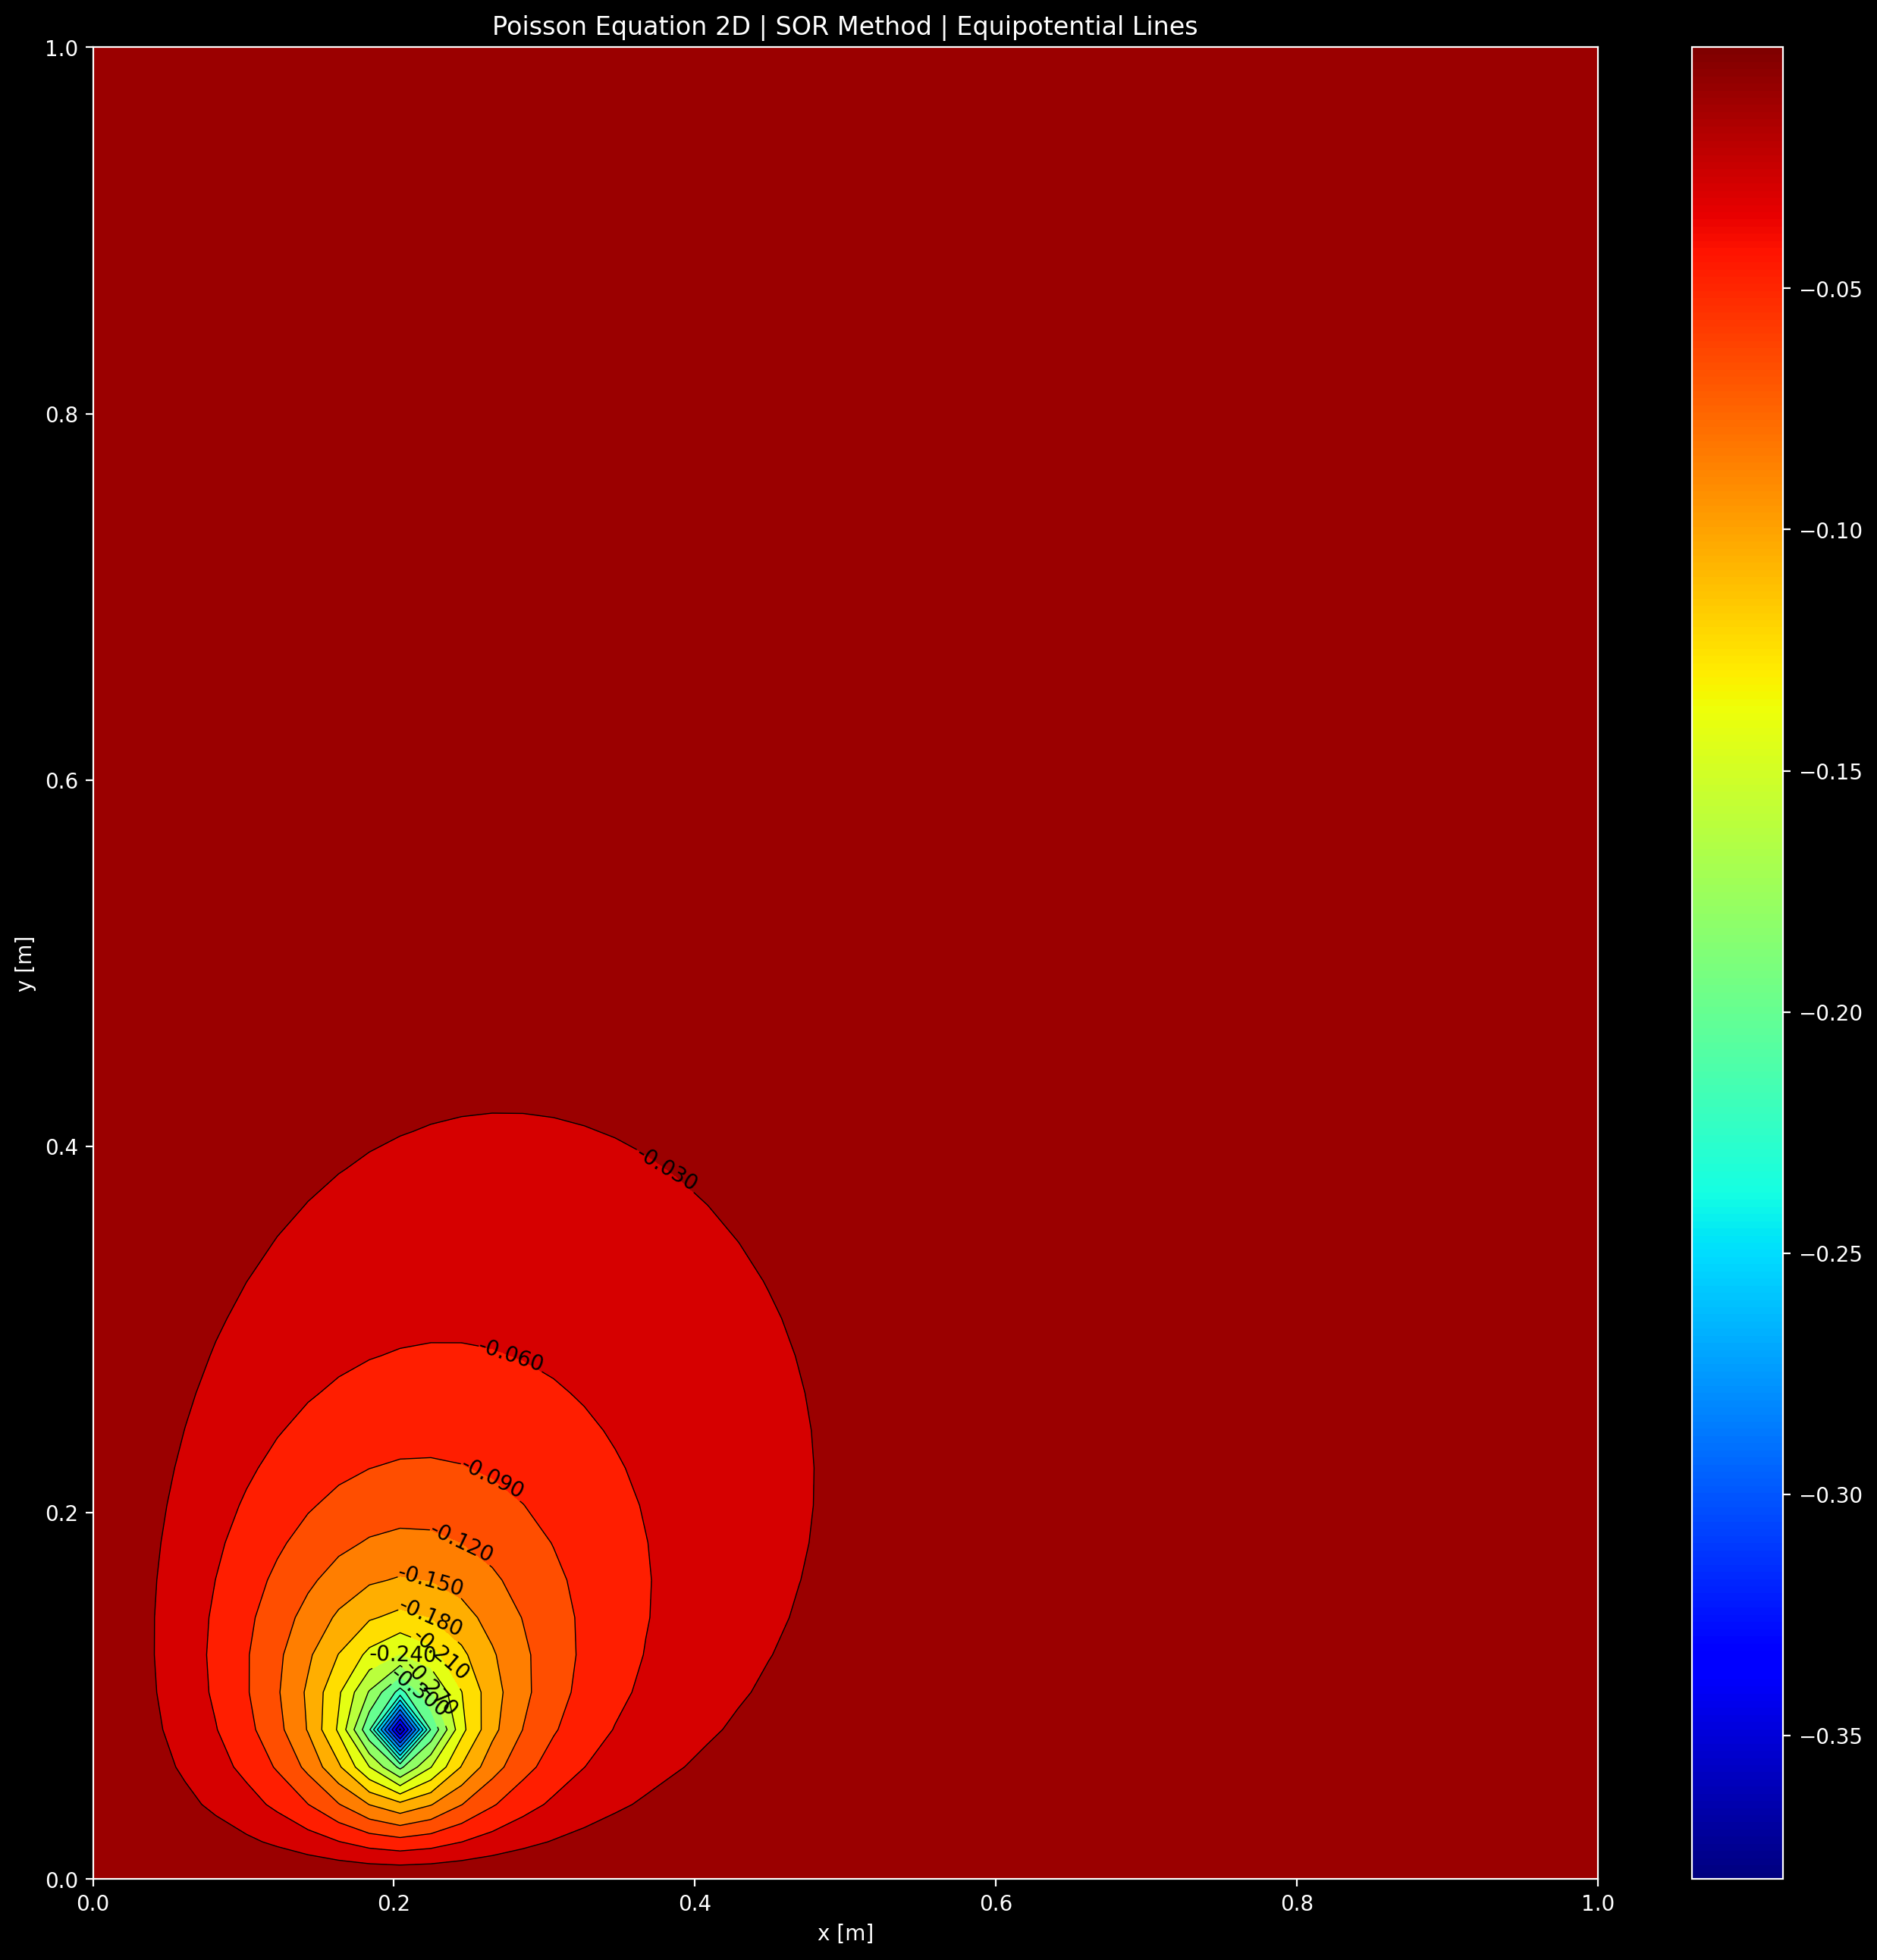

In [34]:
fig, ax = plt.subplots(1,1,figsize=(16,16),dpi=200)
contour = ax.contourf(jj, ii, A, levels=20, linestyles = 'solid', cmap=plt.cm.jet)
contour_lines = ax.contour(jj, ii, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
contour_line_labels = plt.clabel(contour_lines, colors='k')
ax.set_title('Poisson Equation 2D | SOR Method | Equipotential Lines')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
fig.colorbar(surface, ax=ax) 
plt.savefig('plots/P4b_plot.png')

# Problem 5
## E.2 (p.510)

Calculate the period of a non-linear oscillator described by

$$\frac{d^2\theta}{dt^2}=-\sin\theta$$

by numerically integrating

$$\sqrt{8}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos\theta-\cos\theta_m}}$$

for several values of the maximum angle $\theta_m$, using the trapezoidal rule, Simpson's rule, or the Romberg integration method.

In [35]:
%%capture
period = lambda theta_max : quad(lambda theta : np.power(np.cos(theta) - np.cos(theta_max), -0.5), 0, theta_max)[0]
period = np.vectorize(period)
angles = np.linspace(0, 2 * np.pi, 1000)
periods = period(angles)

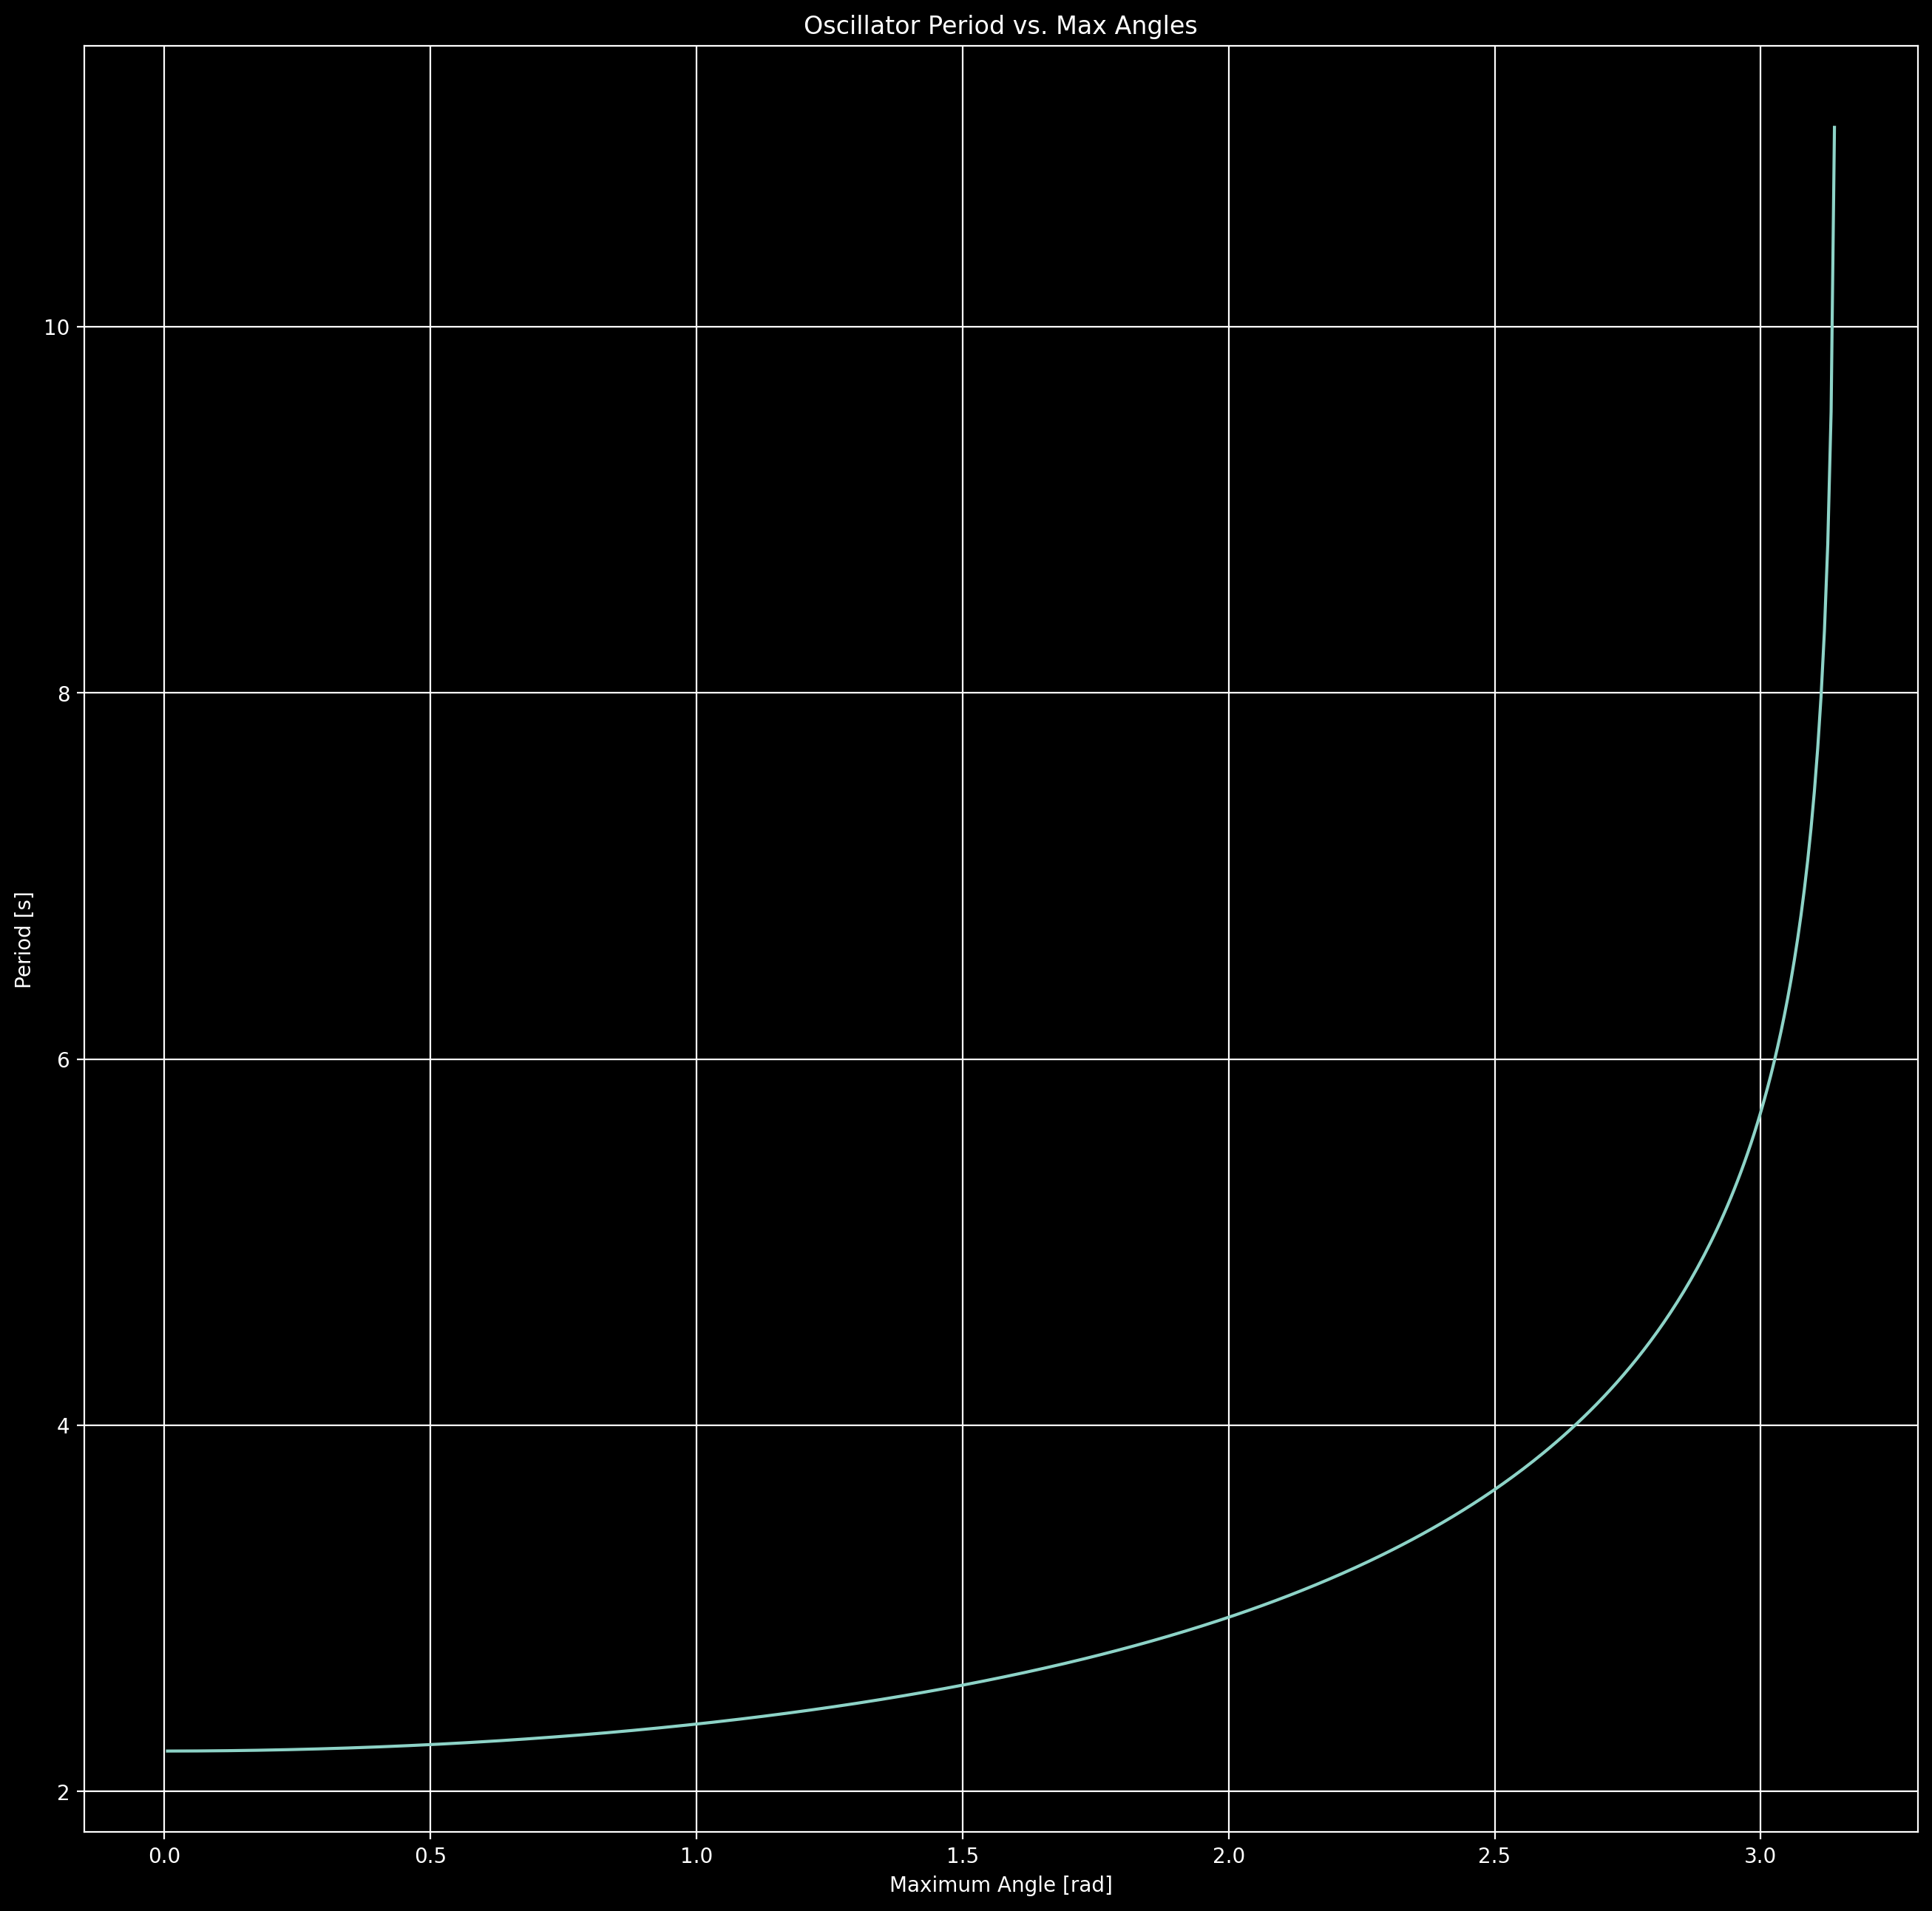

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,16), dpi=200)

ax.plot(angles, periods)

ax.set_xlabel('Maximum Angle [rad]')
ax.set_ylabel('Period [s]')
ax.set_title('Oscillator Period vs. Max Angles')
ax.grid()
plt.savefig('plots/P5_plot.png')